# NEON Paper Plots (Diurnal Cycle + Latent Heat Flux Components) -- Figure 6 + Figure 6 alternate (for all variables)

Author : Negin Sobhani negins@ucar.edu @negin513

Last updated: 2022-10-04
_______

## Creating Diurnal Cycle Plots for NEON sites

This notebooks have the scripts for:

1. Reading Evaluation (NEON) and model (CTSM) data for all neon sites
2. Making diurnal cycle plots for latent heat flux and components for all neon sites
3. Making diurnal cycle plots for all variables without the components. 


# Imports:

In [1]:
import os
import time
import datetime

import numpy as np
import pandas as pd
import xarray as xr

from glob import glob
from os.path import join
from matplotlib import gridspec

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import calendar

import tqdm
import cftime

import seaborn as sns ## -- seaborn only needed for boxplots:


In [2]:
print('xarray '+xr.__version__) ##-- was working with 0.20.0

xarray 0.20.2


## Dask Cluster
The following will spin up a dask cluster,  only works on NCAR machines. 
16 workers worked best for NEON.

In [3]:
from distributed import Client
from ncar_jobqueue import NCARCluster

cluster = NCARCluster()
cluster.scale(16)
client = Client(cluster)
client

/glade/u/apps/opt/conda/envs/npl/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile
/glade/u/apps/opt/conda/envs/npl/lib/python3.7/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42835 instead
  f"Port {expected} is already in use.\n"


<Client: 'tcp://10.12.206.60:33707' processes=0 threads=0, memory=0 B>

## Useful Functions and Objects

In [4]:
def diel_cycle_plot(diel_df_mean, diel_df_std, var, plot_dir,color1= '#e28743',color2='#1d657e',season = "Annual", save_switch=False):
    
    # Plot annual average diel cycle and bias
    bias_var_name = var.obs_var +'_bias'

    diel_df_mean [bias_var_name] = diel_df_mean[var.sim_var]- diel_df_mean[var.obs_var]
    
    fig= plt.figure(num=None, figsize=(17, 13),  facecolor='w', edgecolor='k')

    # -- subplot 1 : Diurnal average + standard dev as shaded regions
    plt.subplot(2, 1, 1)  
    ax = plt.gca()    

    plt.plot ( diel_df_mean.local_hour, diel_df_mean[var.obs_var], marker = 'o' , color = color1,label="NEON")
    plt.plot ( diel_df_mean.local_hour, diel_df_mean[var.sim_var] , marker = 'o' , color = color2,label="CTSM", linestyle = 'dashed')

    plt.fill_between(diel_df_mean.local_hour, diel_df_mean[var.obs_var]-diel_df_std[var.obs_var], diel_df_mean[var.obs_var]+diel_df_std[var.obs_var] ,alpha=0.1, color = color1)
    plt.fill_between(diel_df_mean.local_hour, diel_df_mean[var.sim_var]-diel_df_std[var.sim_var], diel_df_mean[var.sim_var]+diel_df_std[var.sim_var] ,alpha=0.1, color = color2)
    
    ax.set_ylabel(var.long_name+" ["+var.unit+"]", fontsize=15)
    
    # -- vertical line at noon
    # plt.axvline(x=12, color = 'gray',linestyle='dashed',alpha=0.75)

    if season in ["DJF", "MAM","JJA","SON"]:
        plt.title("Diurnal Cycle of "+ var.long_name +"\n " +neon_site+" "+"[2018-2021] " +season , fontweight='bold',fontsize=15)
    else:
        plt.title("Diurnal Cycle of "+ var.long_name +"\n " +neon_site+" "+"[2018-2021]", fontweight='bold',fontsize=15)

    # -- adjusting tick properties.    
    ax.tick_params(axis='both', which='both', labelsize=14,width=1,length=6)
    ax.tick_params(axis='x',direction="in")
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(axis='y',direction="out", length = 7)

    # -- x-axis range and ticks
    ax.set_xlim([-1,24])
    ax.xaxis.set_ticks(np.arange(0, 24, 1))

    # -- y axis label location
    ax.get_yaxis().set_label_coords(-0.06,0.5)

    # -- add legends
    legend_labels, _= ax.get_legend_handles_labels()
    ax.legend(fontsize=15)

    # -- remove tick labels for x axis
    labels = [item.get_text() for item in ax.get_xticklabels()]
    empty_string_labels = ['']*len(labels)
    ax.set_xticklabels(empty_string_labels)   
    
    # ----------------------
    # -- Subplot 2: Bias Plot
    plt.subplot(4, 1, 3)  
    ax = plt.gca()

    diel_df_mean.plot ( x= 'local_hour', y = bias_var_name , marker = 'o' ,ax =ax , color = 'black',label='Bias')
    plt.xlabel('Local Time', fontsize=15)
    plt.ylabel('Bias'+" ["+var.unit+"]", fontsize=15)

    # -- horizontal line at 0 
    plt.axhline(y=0, color = 'gray',linestyle='dashed',alpha=0.75)

    #-- vertical line at noon
    #plt.axvline(x=12, color = 'gray',linestyle='dashed',alpha=0.75)
    
    # -- Changing tick properties:
    ax.tick_params(axis='both', which='both', labelsize=14,width=1,length=7)
    ax.tick_params(axis='x',which ='both',direction="out")
    ax.tick_params(axis='y',direction="out", length = 7)
    ax.yaxis.set_ticks_position('both')

    # -- x-axis range and ticks
    ax.set_xlim([-1,24])
    ax.xaxis.set_ticks(np.arange(0, 24, 1))

    # -- changing x axis tick labels to custom labels
    labels = diel_df_mean.local_hour_dt.dt.strftime("%H:%M")
    ax.set_xticklabels(labels, rotation = 45)
    
    # -- y axis label location
    ax.get_yaxis().set_label_coords(-0.06,0.5)

    # -- remove legend
    ax.get_legend().remove()  

    fig.subplots_adjust(wspace=0, hspace=0)
    
    if save_switch:
        plot_name = neon_site+'_'+plot_var+'_diel_cyle'+'_'+season+'.png'
        print ('Saving '+ os.path.join(plot_dir,plot_name))
        plt.savefig (os.path.join(plot_dir,plot_name), dpi=600,bbox_inches='tight')
        
        plot_name = neon_site+'_'+plot_var+'_diel_cyle'+'_'+season+'.pdf'
        plt.savefig (os.path.join(plot_dir,plot_name), dpi=600,bbox_inches='tight', format = 'pdf')  

    else:
        plt.show()
        
        
def diel_cycle_lh(diel_df_mean, diel_df_std, var, plot_dir,color1= '#e28743',color2='#1d657e',season = "Annual", save_switch=False):

    # Plot annual average diel cycle and bias
    bias_var_name = var.obs_var +'_bias'

    diel_df_mean [bias_var_name] = diel_df_mean[var.sim_var]- diel_df_mean[var.obs_var]
    
    fig= plt.figure(num=None, figsize=(17, 15),  facecolor='w', edgecolor='k')

    # -- subplot 1 : Diurnal average + standard dev as shaded regions
    gs = gridspec.GridSpec(3, 1, height_ratios=[3, 1, 2.25]) 
    ax= plt.subplot(gs[0])

    plt.plot ( diel_df_mean.local_hour, diel_df_mean[var.obs_var], marker = 'o' , color = color1,label="NEON")
    plt.plot ( diel_df_mean.local_hour, diel_df_mean[var.sim_var] , marker = 'o' , color = color2,label="CTSM", linestyle = 'dashed')

    plt.fill_between(diel_df_mean.local_hour, diel_df_mean[var.obs_var]-diel_df_std[var.obs_var], diel_df_mean[var.obs_var]+diel_df_std[var.obs_var] ,alpha=0.1, color = color1)
    plt.fill_between(diel_df_mean.local_hour, diel_df_mean[var.sim_var]-diel_df_std[var.sim_var], diel_df_mean[var.sim_var]+diel_df_std[var.sim_var] ,alpha=0.1, color = color2)
    
    ax.set_ylabel(var.long_name+" ["+var.unit+"]", fontsize=15)
    
    # -- vertical line at noon
    #plt.axvline(x=12, color = 'gray',linestyle='dashed',alpha=0.75)

    if season in ["DJF", "MAM","JJA","SON"]:
        plt.title("Diurnal Cycle of "+ var.long_name +"\n " +neon_site+" "+"[2018-2021] " +season , fontweight='bold',fontsize=15)
    else:
        plt.title("Diurnal Cycle of "+ var.long_name +"\n " +neon_site+" "+"[2018-2021]", fontweight='bold',fontsize=15)

    # -- Changing tick properties:
    ax.tick_params(axis='both', which='both', labelsize=14,width=1,length=7)
    ax.tick_params(axis='x',which ='both',direction="in")
    ax.tick_params(axis='y',direction="out", length = 7)
    ax.yaxis.set_ticks_position('both')

    # -- x-axis range and ticks
    ax.set_xlim([-1,24])
    ax.xaxis.set_ticks(np.arange(0, 24, 1))

    # -- y axis label location
    ax.get_yaxis().set_label_coords(-0.07,0.5)
    
    # -- add legends
    legend_labels, _= ax.get_legend_handles_labels()
    ax.legend(fontsize=15)

    # -- add letters
    ax.text(.01,0.935,'(a)',
        horizontalalignment='left',
        transform=ax.transAxes, fontweight='bold',fontsize=15)


    # -- remove tick labels for x axis
    labels = [item.get_text() for item in ax.get_xticklabels()]
    empty_string_labels = ['']*len(labels)
    ax.set_xticklabels(empty_string_labels)   
    
    # ----------------------
    # -- Subplot 2: Bias Plot
    ax = plt.subplot(gs[1])

    diel_df_mean.plot ( x= 'local_hour', y = 'EFLX_LH_TOT_bias' , marker = 'o' ,ax =ax , color = 'black',label='Bias')
    plt.ylabel('Bias'+" ["+var.unit+"]", fontsize=15)
    
    # -- horizontal line at 0 
    plt.axhline(y=0, color = 'gray',linestyle='dashed',alpha=0.75)

    #-- vertical line at noon
    #plt.axvline(x=12, color = 'gray',linestyle='dashed',alpha=0.75)

    # -- Changing tick properties:
    ax.tick_params(axis='both', which='both', labelsize=14,width=1,length=7)
    ax.tick_params(axis='x',which ='both',direction="in")
    ax.tick_params(axis='y',direction="out", length = 7)
    ax.yaxis.set_ticks_position('both')

    # -- x-axis range and ticks
    ax.set_xlim([-1,24])
    ax.xaxis.set_ticks(np.arange(0, 24, 1))

    # -- y axis label location
    ax.get_yaxis().set_label_coords(-0.07,0.5)

    # -- remove legend
    ax.get_legend().remove()

    # -- add letters
    ax.text(.01,0.8,'(b)',
        horizontalalignment='left',
        transform=ax.transAxes, fontweight='bold',fontsize=15)

    # -- remove tick labels for x axis
    labels = [item.get_text() for item in ax.get_xticklabels()]
    empty_string_labels = ['']*len(labels)
    ax.set_xticklabels(empty_string_labels)    

    # ----------------------
    # -- Subplot 3: Latent Heat Flux Composition Plots
    ax = plt.subplot(gs[2])
    diel_df_mean[['local_hour','sim_FCEV','sim_FCTR','sim_FGEV']].plot.bar ( x= 'local_hour',stacked='True',ax=ax,rot=45)
    
    #-- vertical line at noon
    #plt.axvline(x=12, color = 'gray',linestyle='dashed',alpha=0.75)

    plt.ylabel('Latent Heat Components'+" ["+var.unit+"]", fontsize=15)
    plt.xlabel('Local Time', fontsize=15)

    # -- Changing tick properties:
    ax.tick_params(axis='both', which='both', labelsize=14,width=1,length=7)
    ax.tick_params(axis='x',which ='both',direction="out")
    ax.tick_params(axis='y',direction="out", length = 7)
    
    ax.yaxis.set_ticks_position('both')

    # -- x-axis range and ticks
    ax.set_xlim([-1,24])
    ax.xaxis.set_ticks(np.arange(0, 24, 1))

    # -- changing x axis tick labels to custom labels
    labels = diel_df_mean.local_hour_dt.dt.strftime("%H:%M")
    ax.set_xticklabels(labels)

    # -- y axis label location
    ax.get_yaxis().set_label_coords(-0.07,0.5)

    # -- add legends
    legend_labels, _= ax.get_legend_handles_labels()
    ax.legend(legend_labels, ['Canopy Evaporation','Canopy Transpiration', 'Ground Evaporation'],fontsize=15)

    # -- add letters 
    ax.text(.01,0.9,'(c)',
        horizontalalignment='left',
        transform=ax.transAxes, fontweight='bold',fontsize=15)
    
    fig.subplots_adjust(wspace=0, hspace=0)
        
    if save_switch:
        plot_name = neon_site+'_'+plot_var+'_composition_diel_cyle'+'_'+season+'.png'
        print ('Saving '+ os.path.join(plot_dir,plot_name))
        plt.savefig (os.path.join(plot_dir,plot_name), dpi=600,bbox_inches='tight')
        
        plot_name = neon_site+'_'+plot_var+'_composition_diel_cyle'+'_'+season+'.pdf'
        plt.savefig (os.path.join(plot_dir,plot_name), dpi=600,bbox_inches='tight', format = 'pdf')  

    else:
        plt.show()

In [6]:
class PlotVariable ():
  def __init__(self, short_name, long_name, unit):
    self.short_name = short_name
    self.long_name = long_name
    self.unit = unit
    self.obs_var = short_name
    self.sim_var = 'sim_'+short_name


## Variables to create plots

Create a list of variables instances for the plots. 

In [7]:
all_vars= [] 

plot_var = 'Rnet'
sim_var = 'sim_'+plot_var
plot_var_desc = "Net Radiation"
plot_var_unit= "Wm⁻²"
this_var = PlotVariable(plot_var, plot_var_desc, plot_var_unit)
all_vars.append(this_var)

plot_var = 'FSH'
sim_var = 'sim_'+plot_var
plot_var_desc = 'Sensible Heat Flux'
plot_var_unit= "Wm⁻²"
this_var = PlotVariable(plot_var, plot_var_desc, plot_var_unit)
all_vars.append(this_var)

plot_var = 'EFLX_LH_TOT'
sim_var = 'sim_'+plot_var
plot_var_desc = "Latent Heat Flux"
plot_var_unit= "Wm⁻²"
this_var = PlotVariable(plot_var, plot_var_desc, plot_var_unit)
all_vars.append(this_var)



plot_var = 'GPP'
sim_var = 'sim_'+plot_var
plot_var_desc = "Gross Primary Production"
plot_var_unit= "gCm⁻²day⁻¹"
this_var = PlotVariable(plot_var, plot_var_desc, plot_var_unit)
all_vars.append(this_var)


plot_var = 'NEE'
sim_var = 'sim_'+plot_var
plot_var_desc = "Net Ecosystem Exchange"
plot_var_unit= "gCm⁻²day⁻¹"
this_var = PlotVariable(plot_var, plot_var_desc, plot_var_unit)
all_vars.append(this_var)

---------------------------
## Make Diurnal Cycle Plots

In [8]:
# -- read list of sites:
neon_sites_pft = pd.read_csv('/glade/scratch/negins/preprocessed_neon_csv_data/neon_sites_dompft.csv')
neon_sites = neon_sites_pft['Site'].to_list()

failed_sites = [] # -- list for saving failed sites

In [9]:
# -- read only these variables from the whole netcdf files
def preprocess (ds):
    variables = ['FCEV', 'FCTR', 'FGEV','FSH','GPP','FSA','FIRA','AR','HR','ELAI']

    ds_new= ds[variables]
    return ds_new

In [10]:
# -- fix timestamp on CTSM files so they can be matched with eval files
def fix_time (ds):
    '''
    fix time formatting with reading multiple cesm files.
    '''
    nsteps = len(ds.time)
    yr0 = ds['time.year'][0].values
    month0 = ds['time.month'][0].values
    day0 = ds['time.day'][0].values

    date = cftime.datetime(yr0,month0,day0).isoformat() 
    ds['time'] = xr.cftime_range(date, periods=nsteps, freq='30min')
    ds['time']= ds['time'].dt.strftime("%Y-%m-%d %H:%M:%S")
    return ds

In [11]:
plot_dir = "/glade/work/negins/neon_vis_plots/paper_plots_final/"

if not os.path.exists (plot_dir):
    print ("plot directory does not exist... creating it now!")
    os.mkdir(plot_dir)

In [12]:
## -- Setting some defaults for our figures:
plt.rcParams["font.weight"] = "bold"    
plt.rcParams["axes.labelweight"] = "bold"
font = {'weight' : 'bold',
        'size'   : 15} 
matplotlib.rc('font', **font)

Going Through the list of sites and make plots for all of them.
If you want to save your plots change `save_switch = True`. 

---------------------------
Making plots for BART
All simulation files for all years: [ 1461 files]
Start reading v2 simulation files...
Reading all simulation files took: 13.23022174835205 s.
All evaluation files for all years: [ 48 files]
Start reading v2 evaluation files...
Reading all observation files took: 1.6207804679870605 s.
Processing data...
Making diurnal cycle plots...


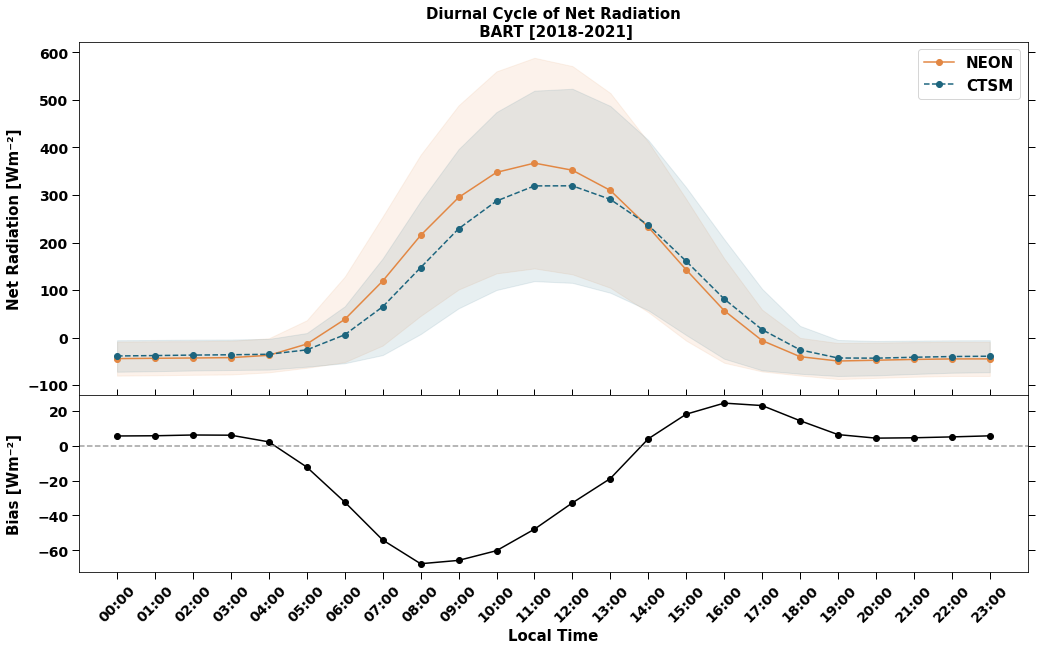

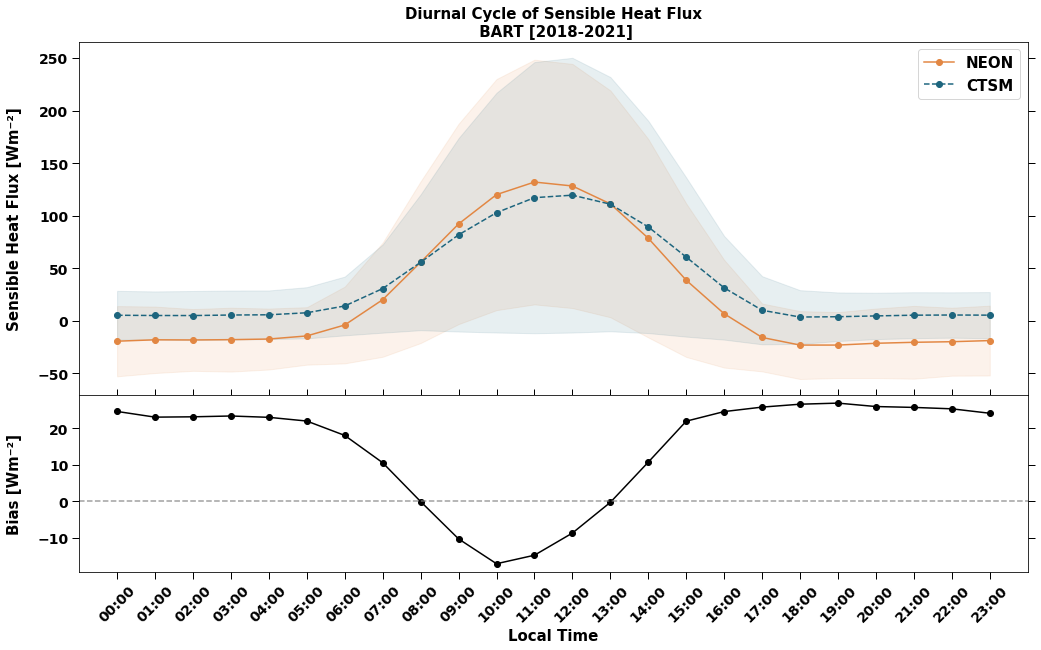

making latent heat component plots


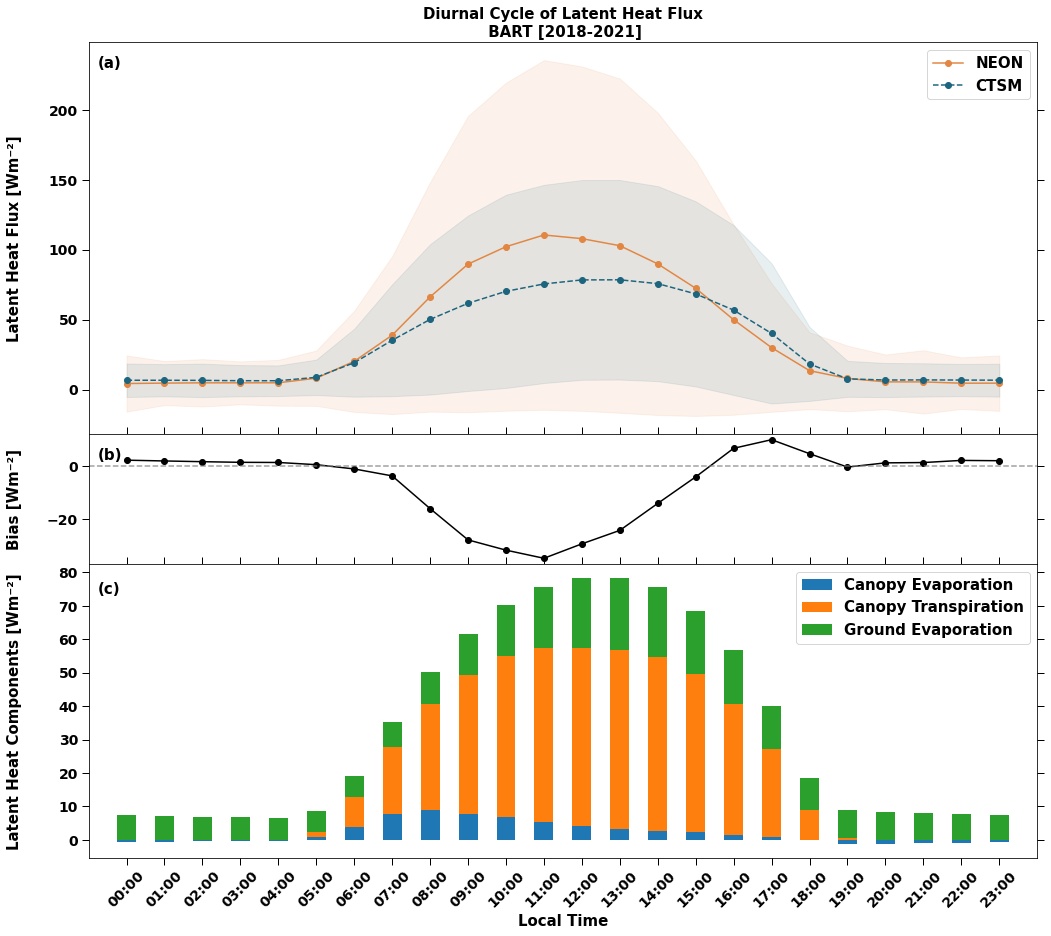

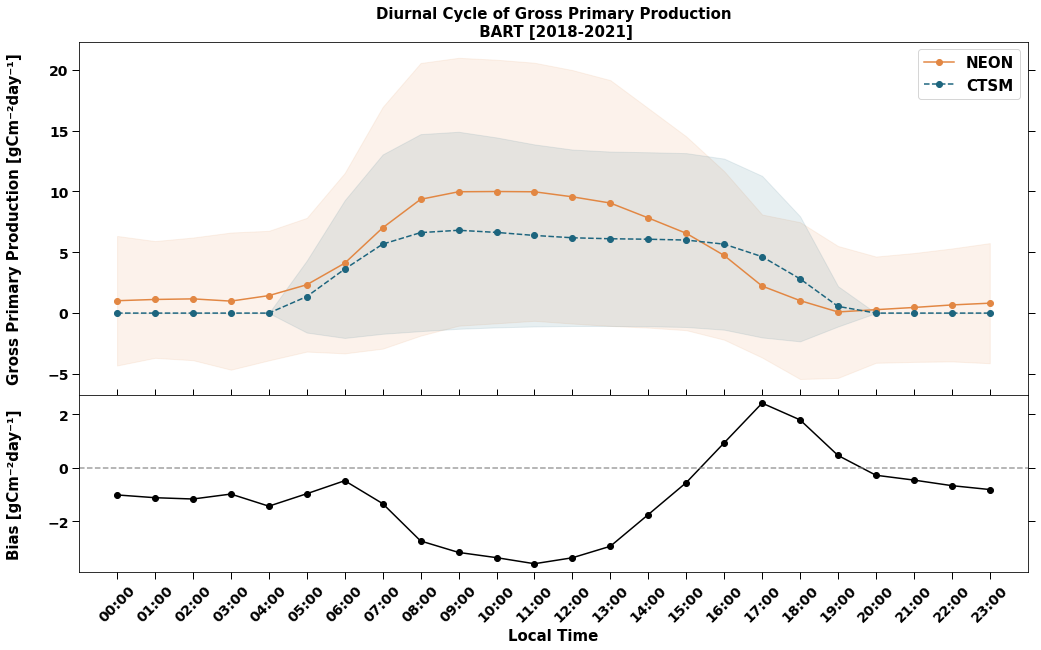

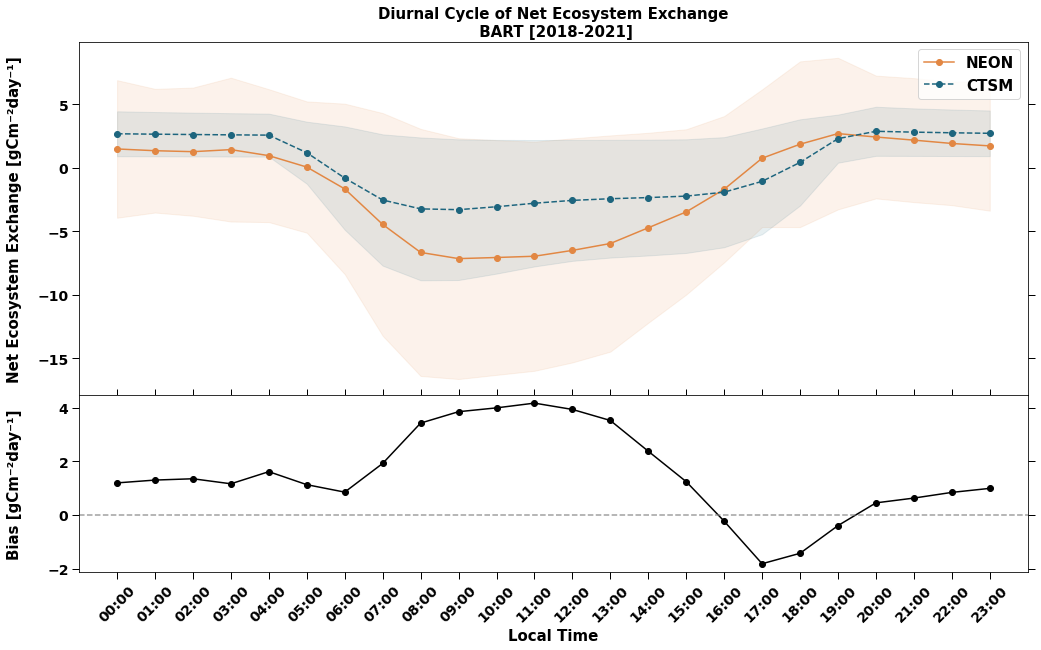

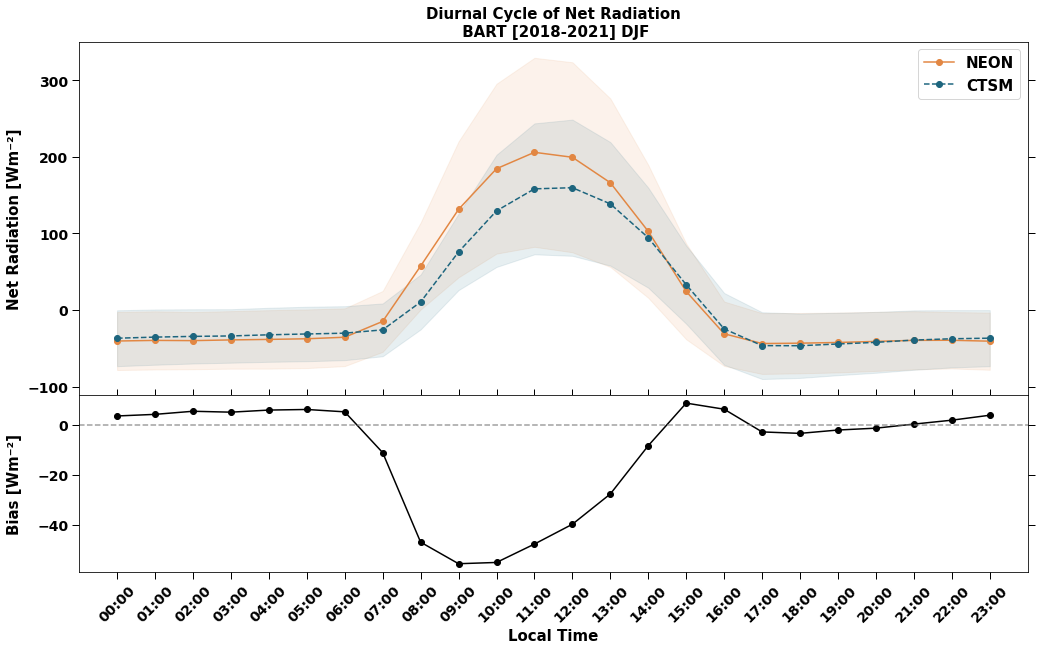

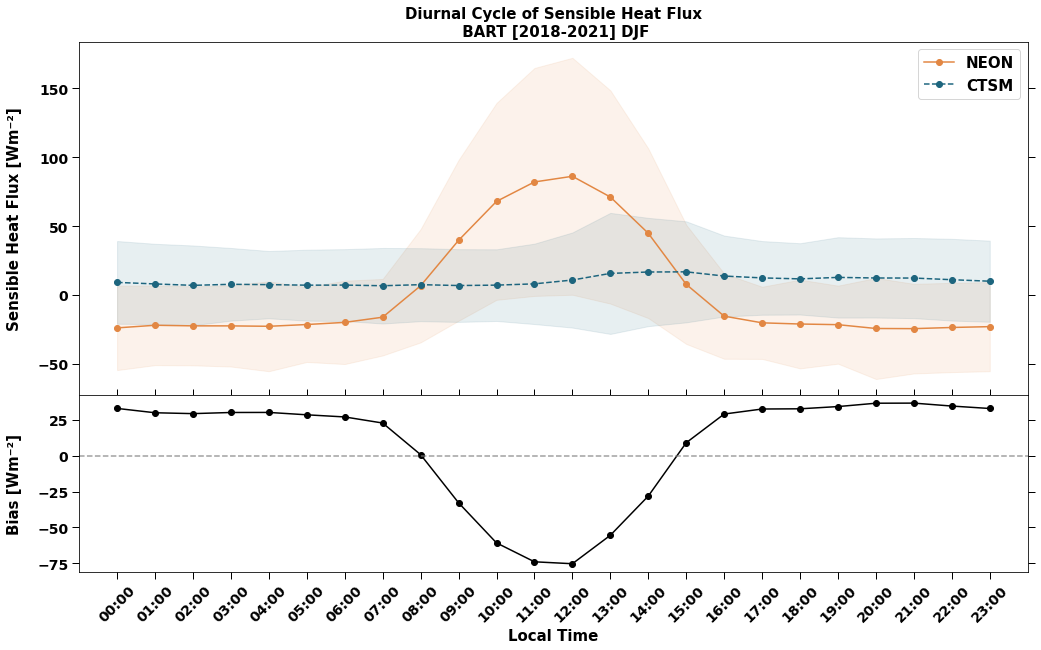

making latent heat component plots


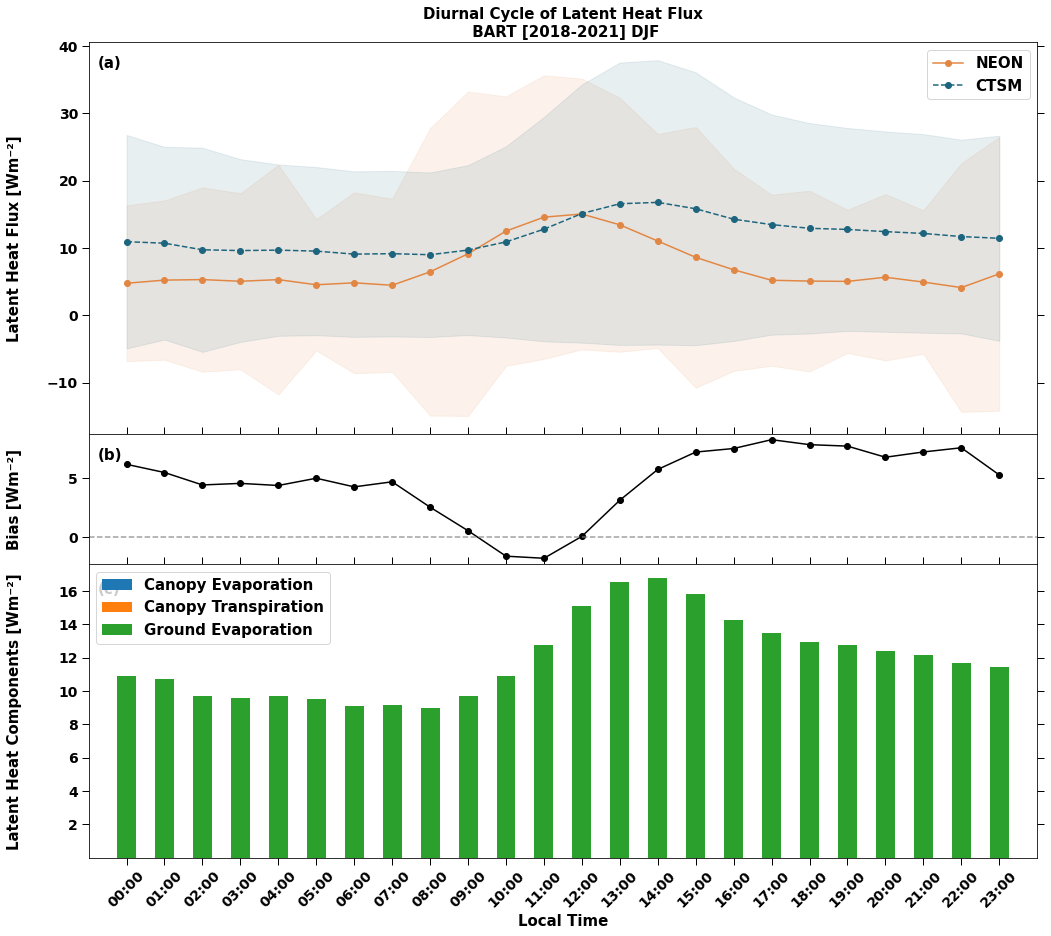

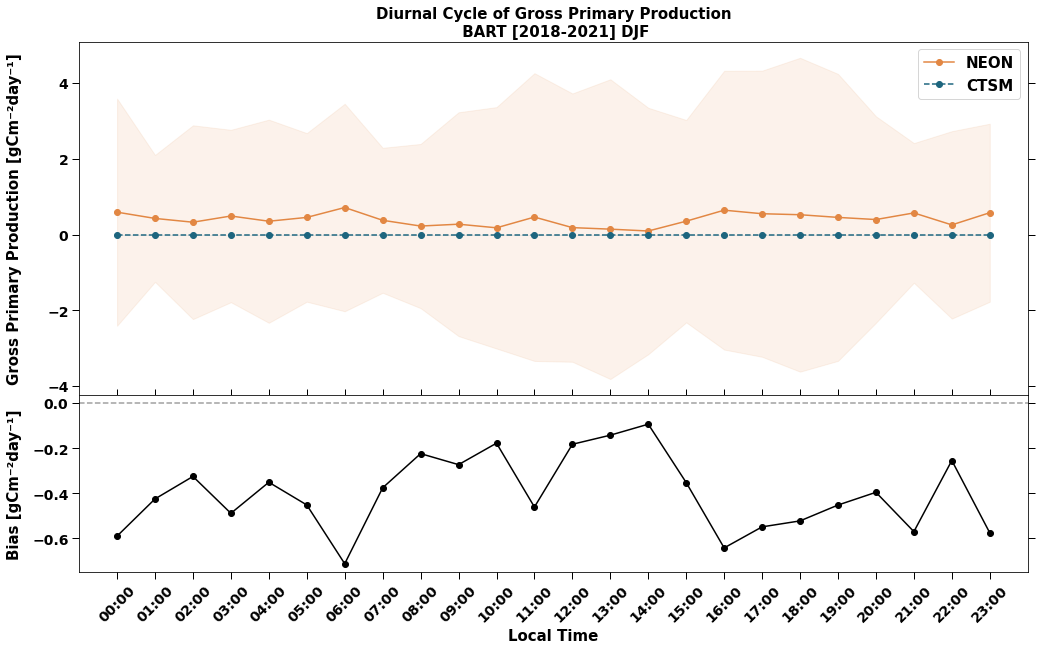

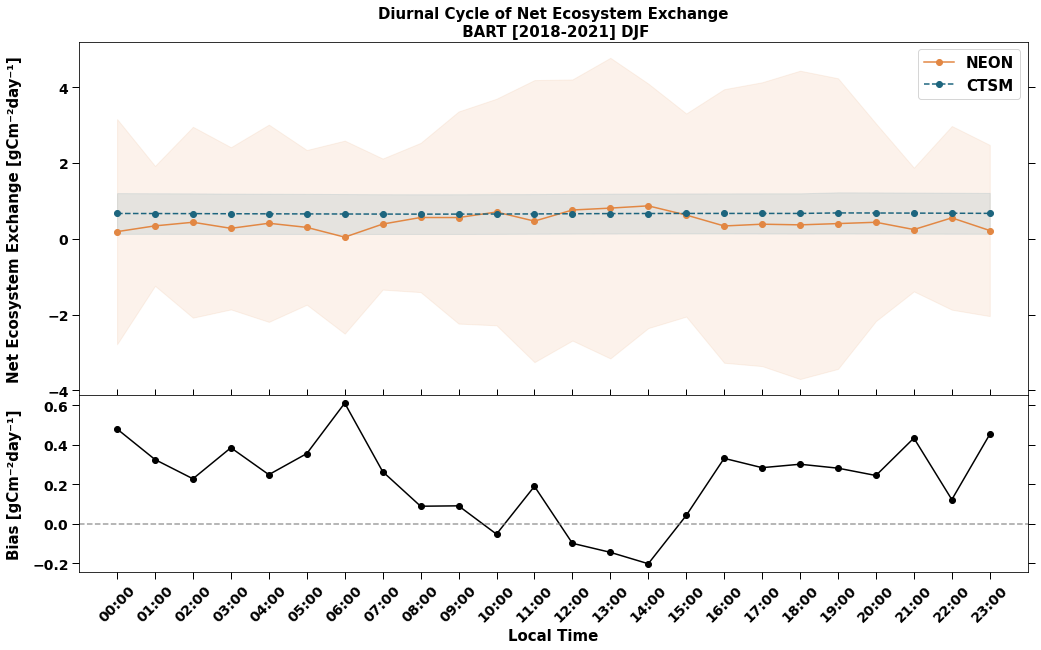

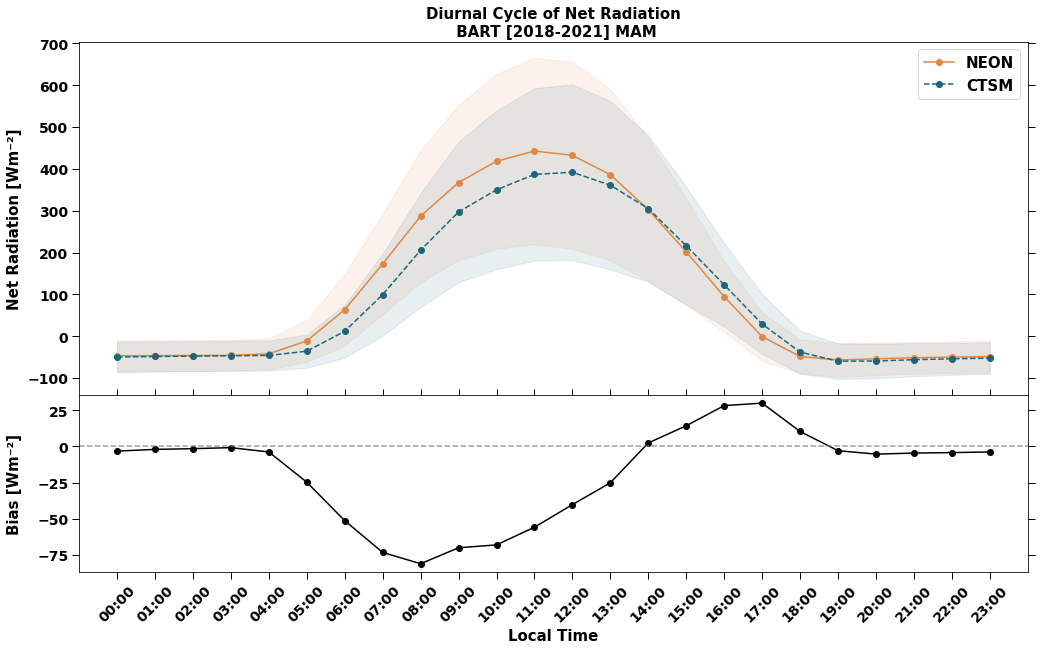

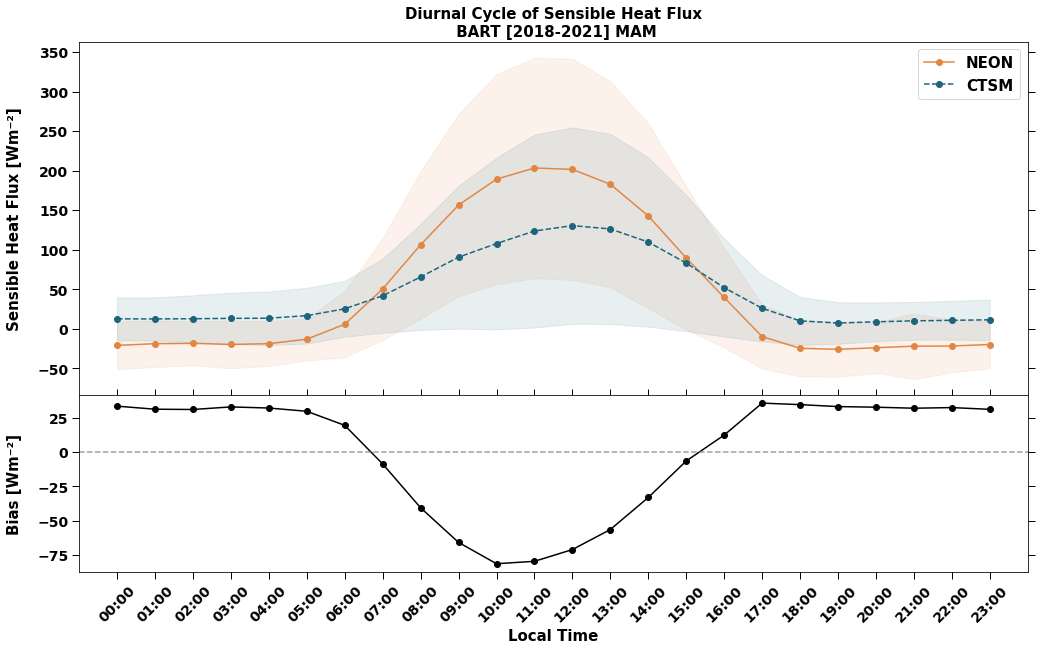

making latent heat component plots


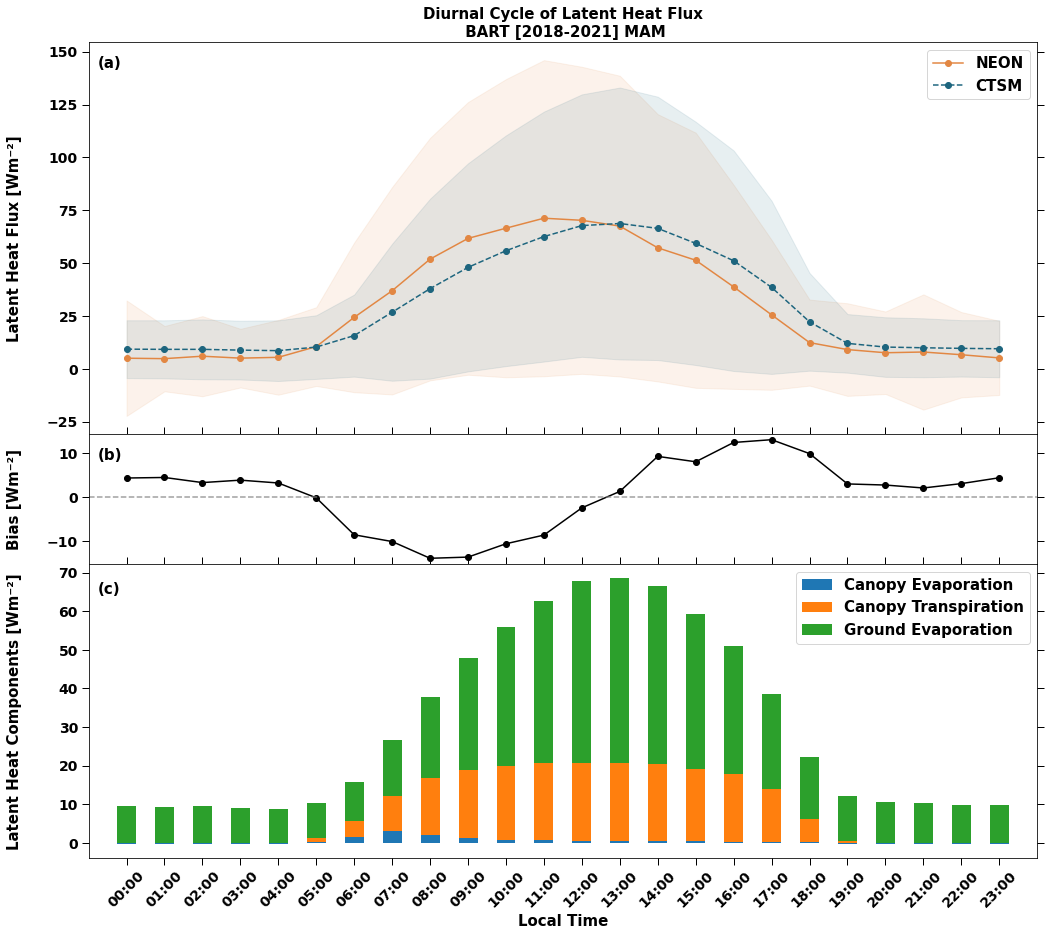

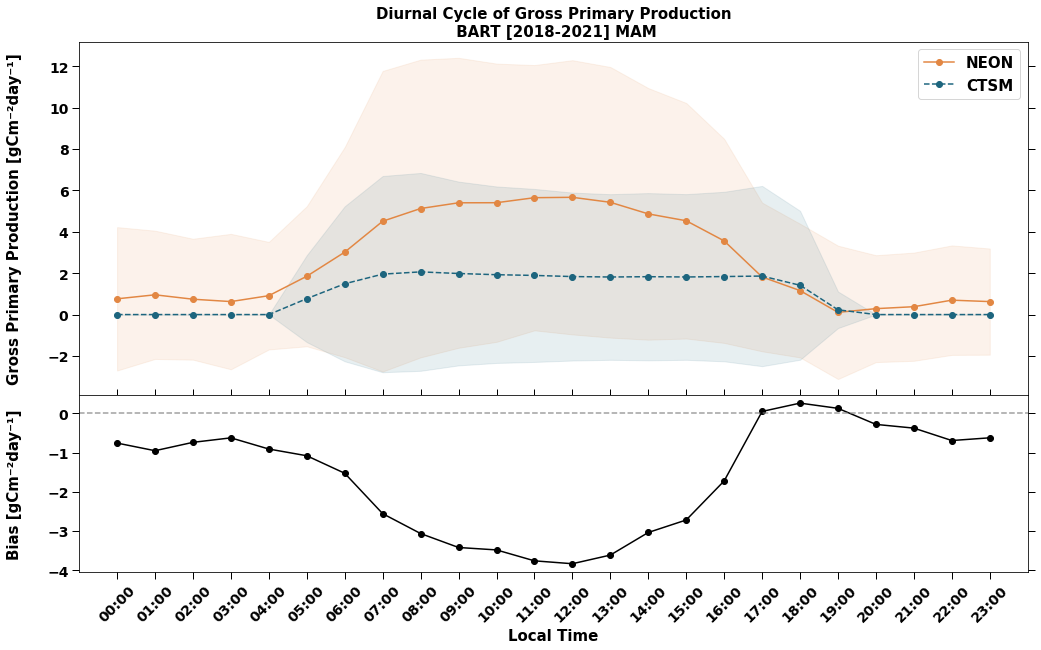

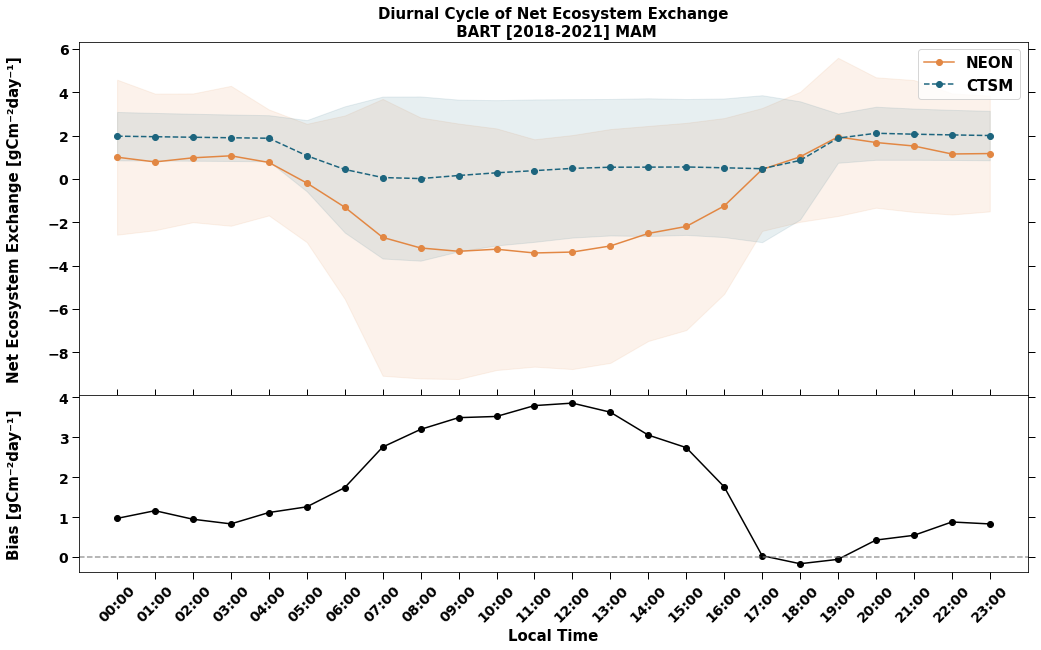

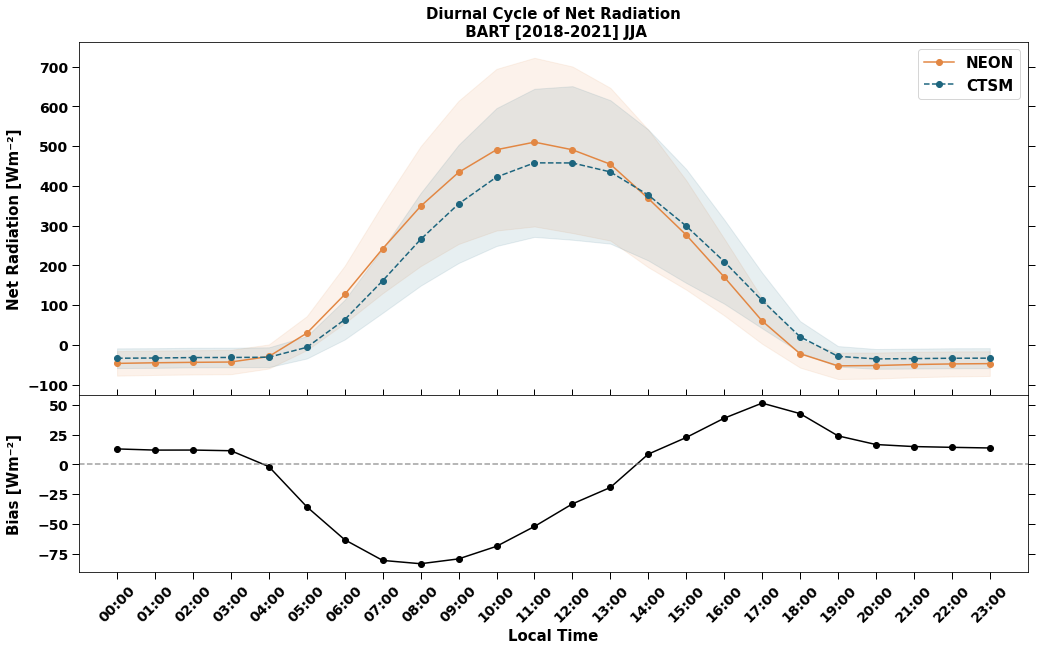

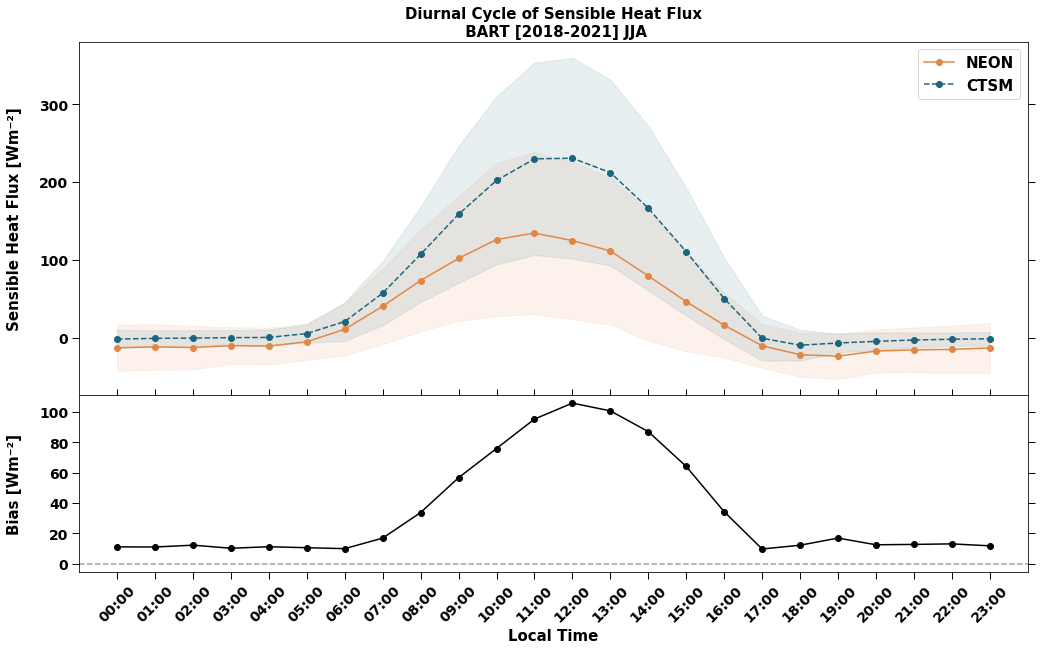

making latent heat component plots


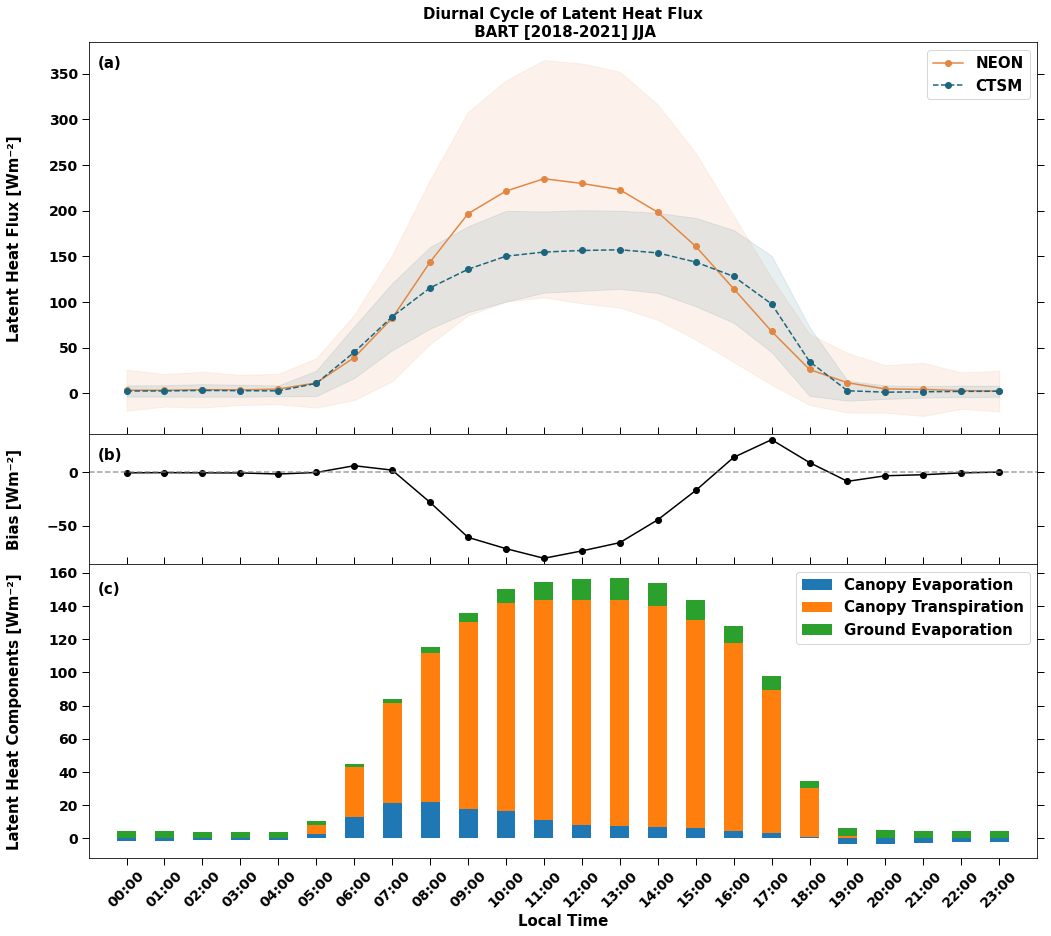

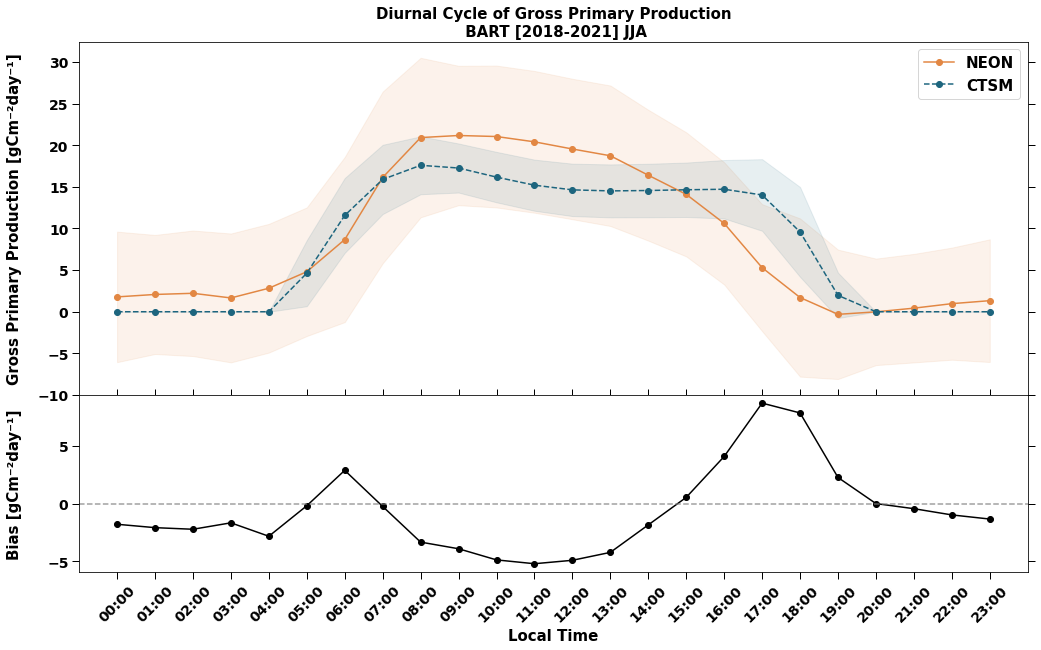

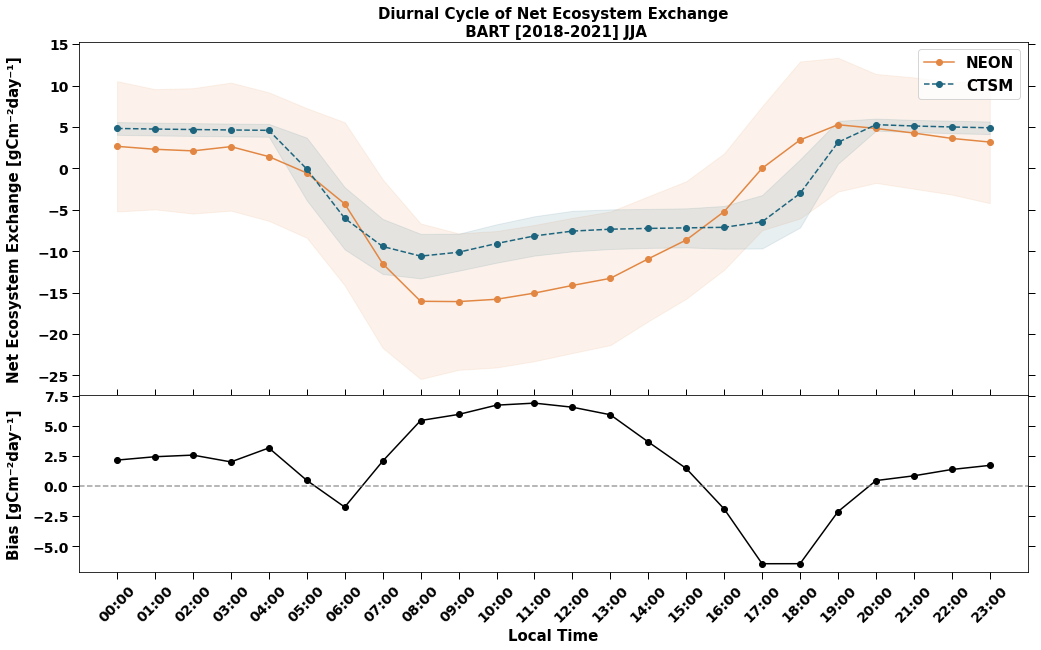

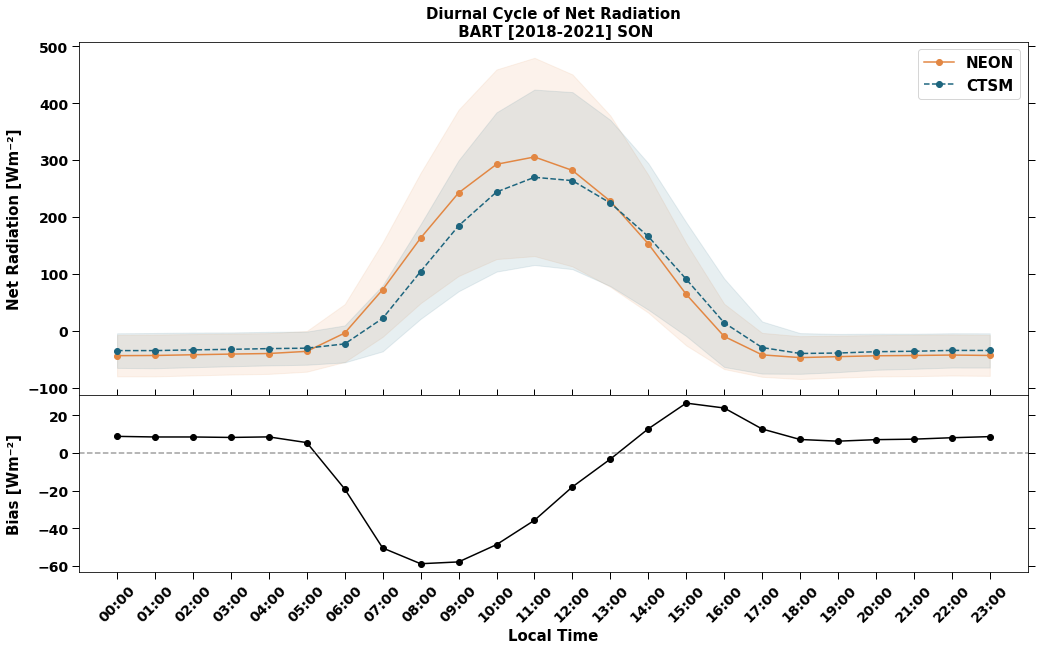

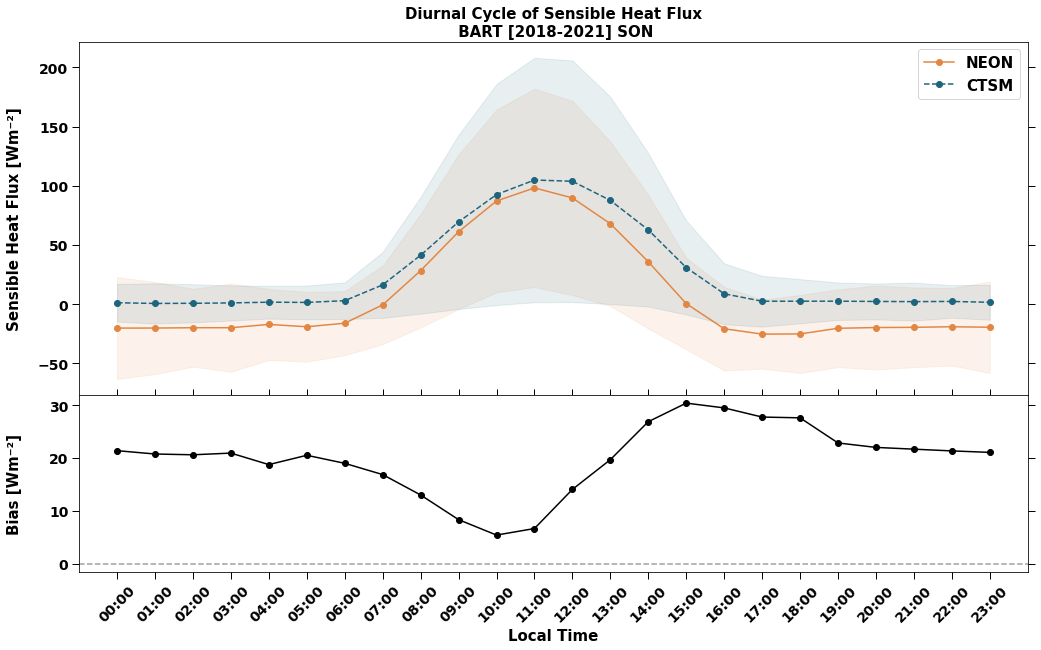

making latent heat component plots


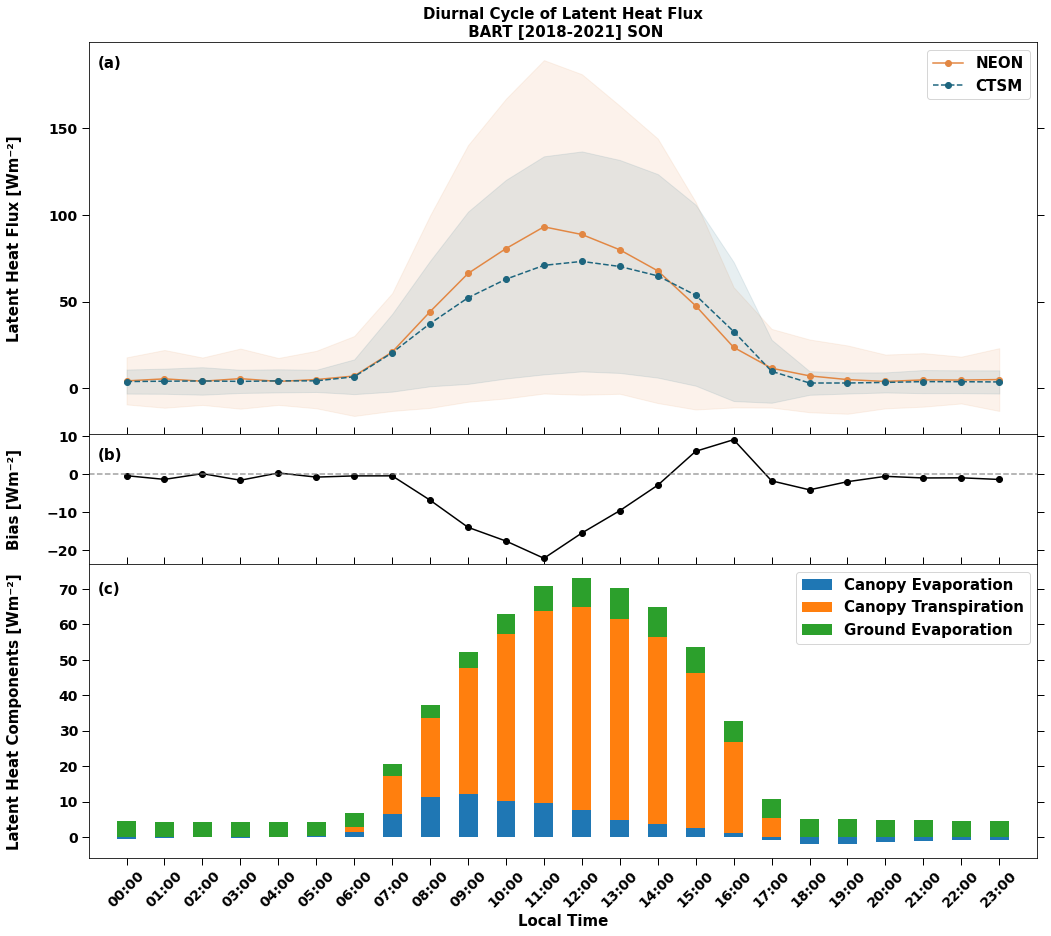

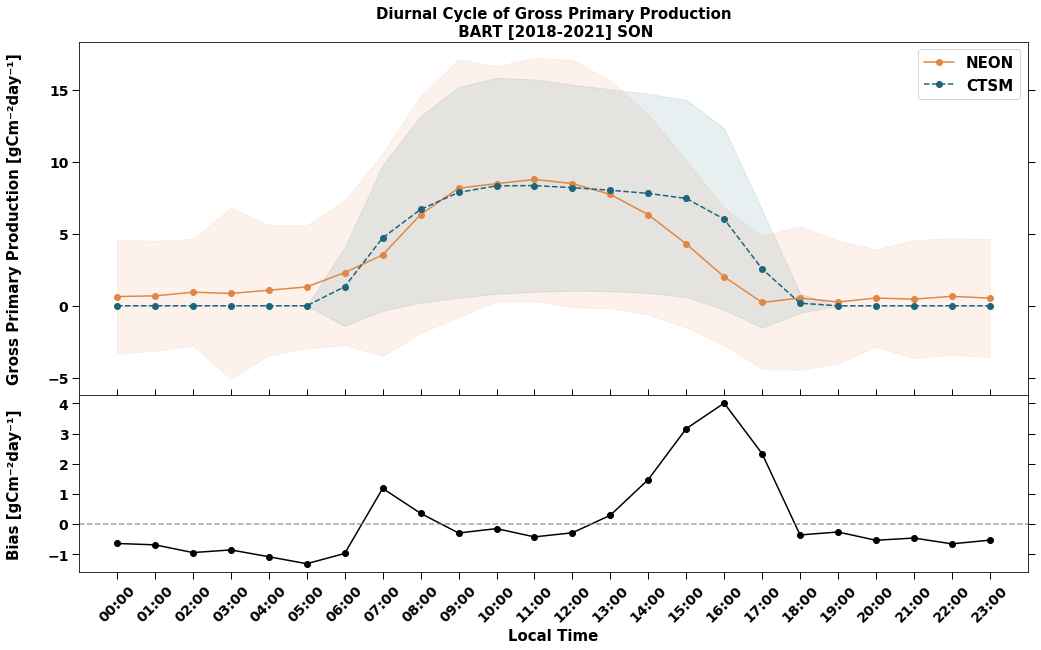

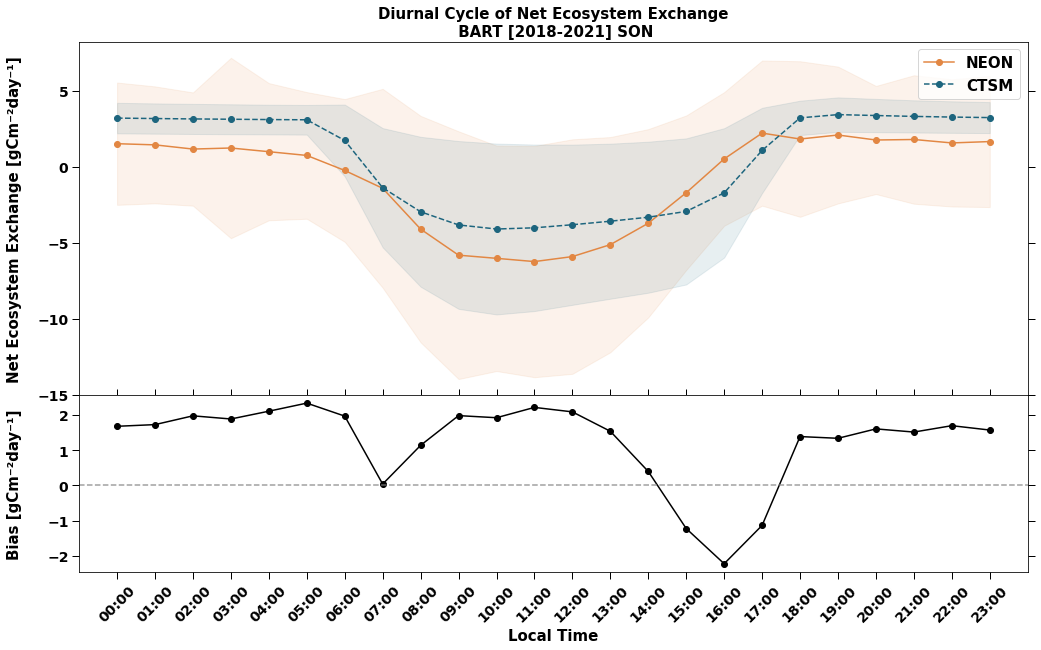

Making these plots for BART took :  43.914690256118774 s.
---------------------------
Making plots for ABBY
All simulation files for all years: [ 1461 files]
Start reading v2 simulation files...
Reading all simulation files took: 12.752138376235962 s.
All evaluation files for all years: [ 48 files]
Start reading v2 evaluation files...
Reading all observation files took: 1.8036532402038574 s.
Processing data...
Making diurnal cycle plots...


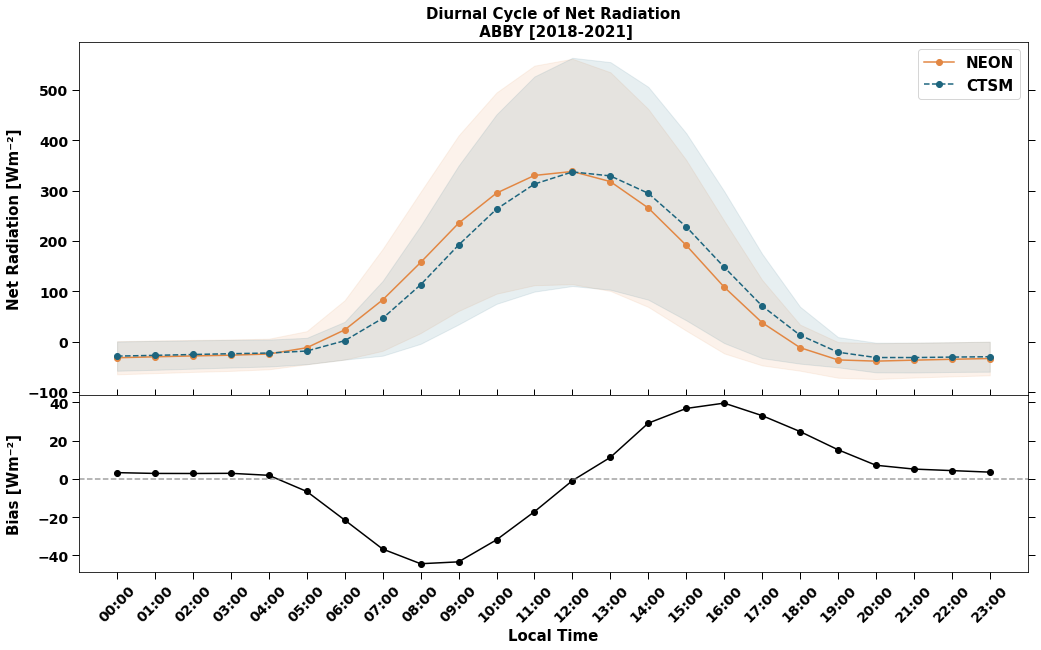

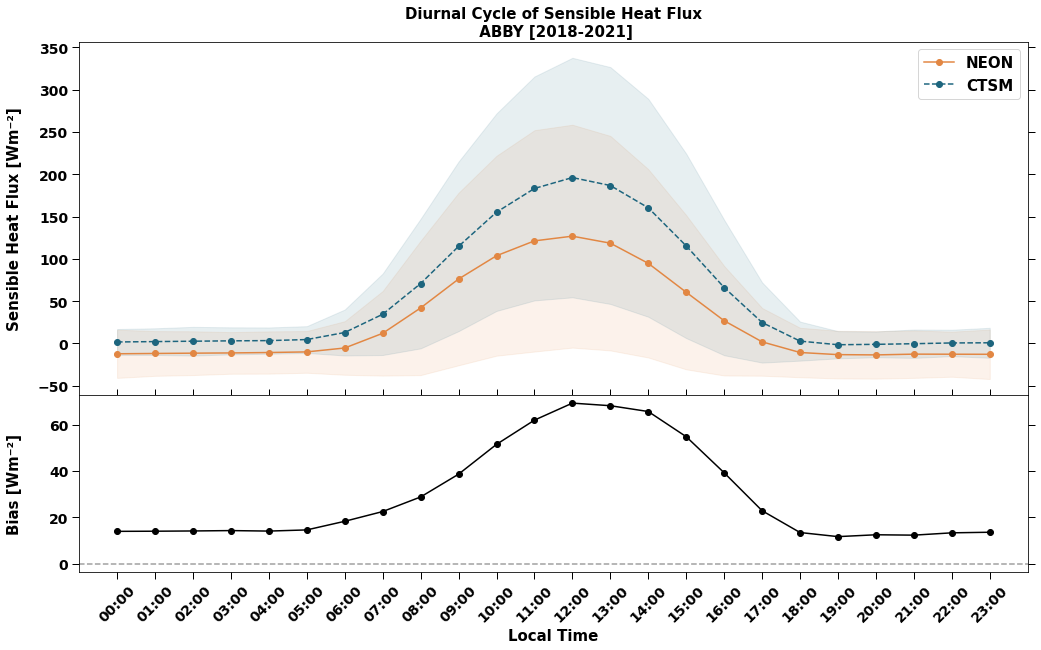

making latent heat component plots


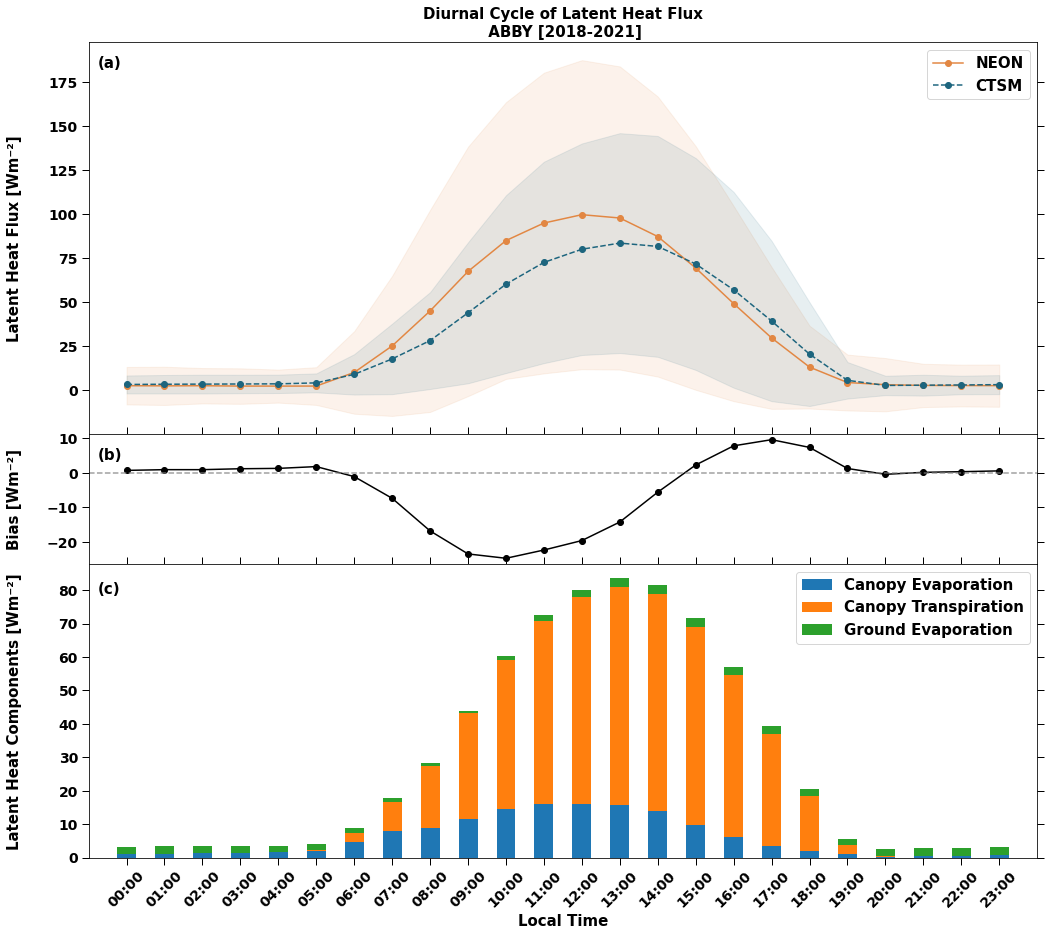

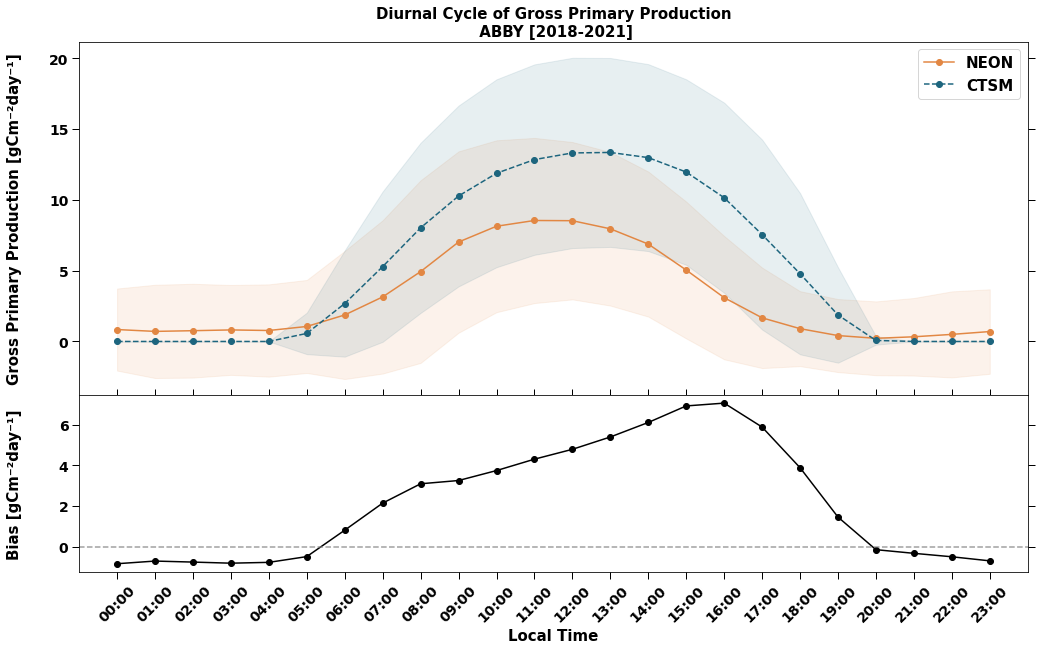

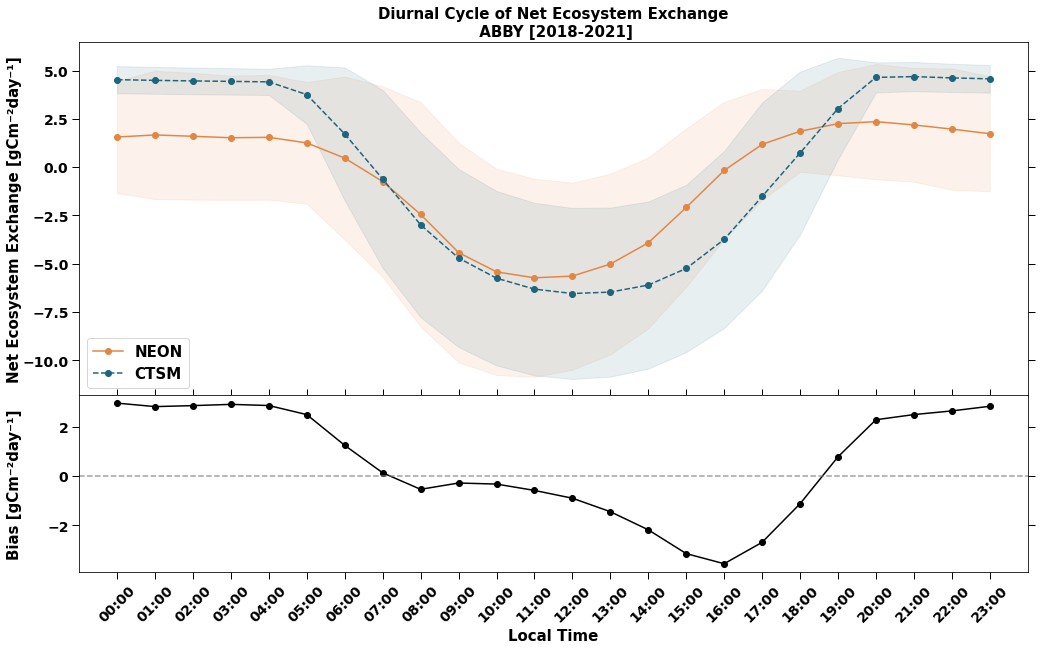

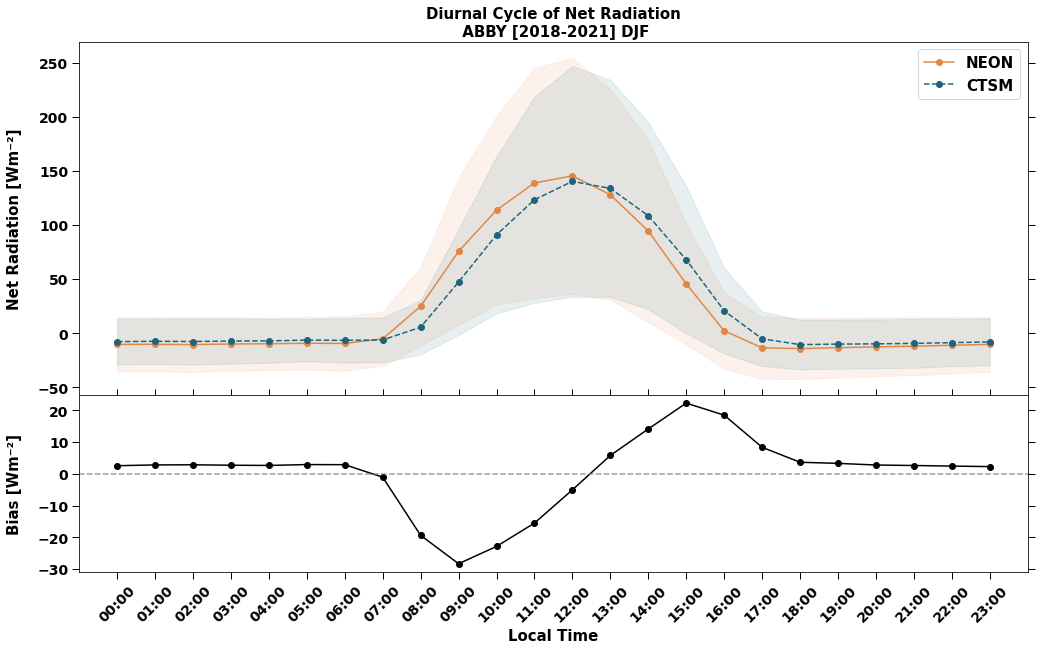

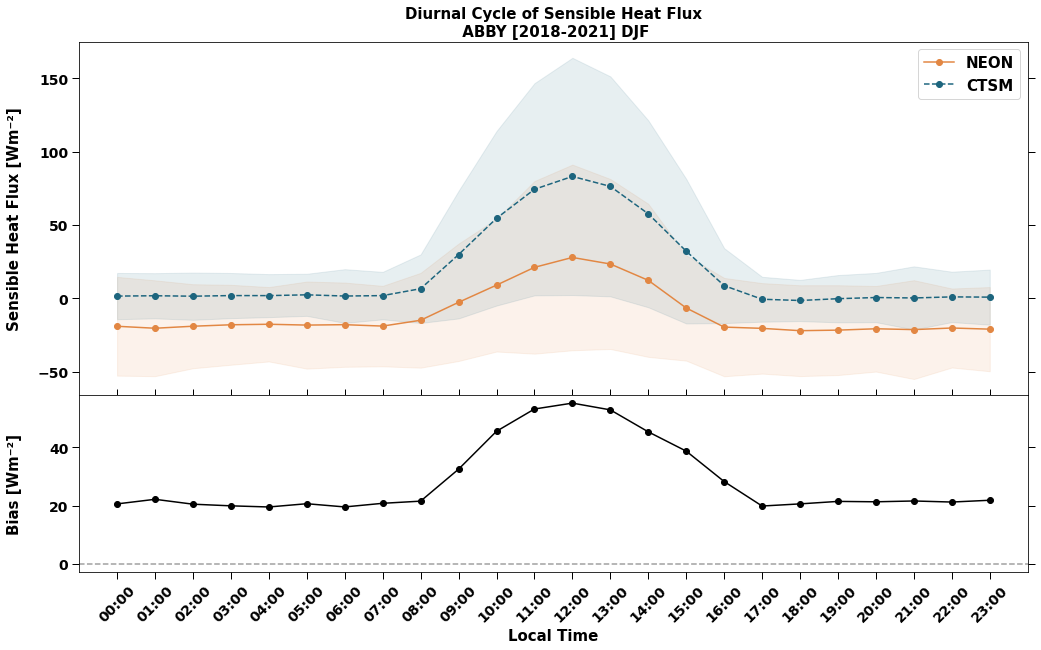

making latent heat component plots


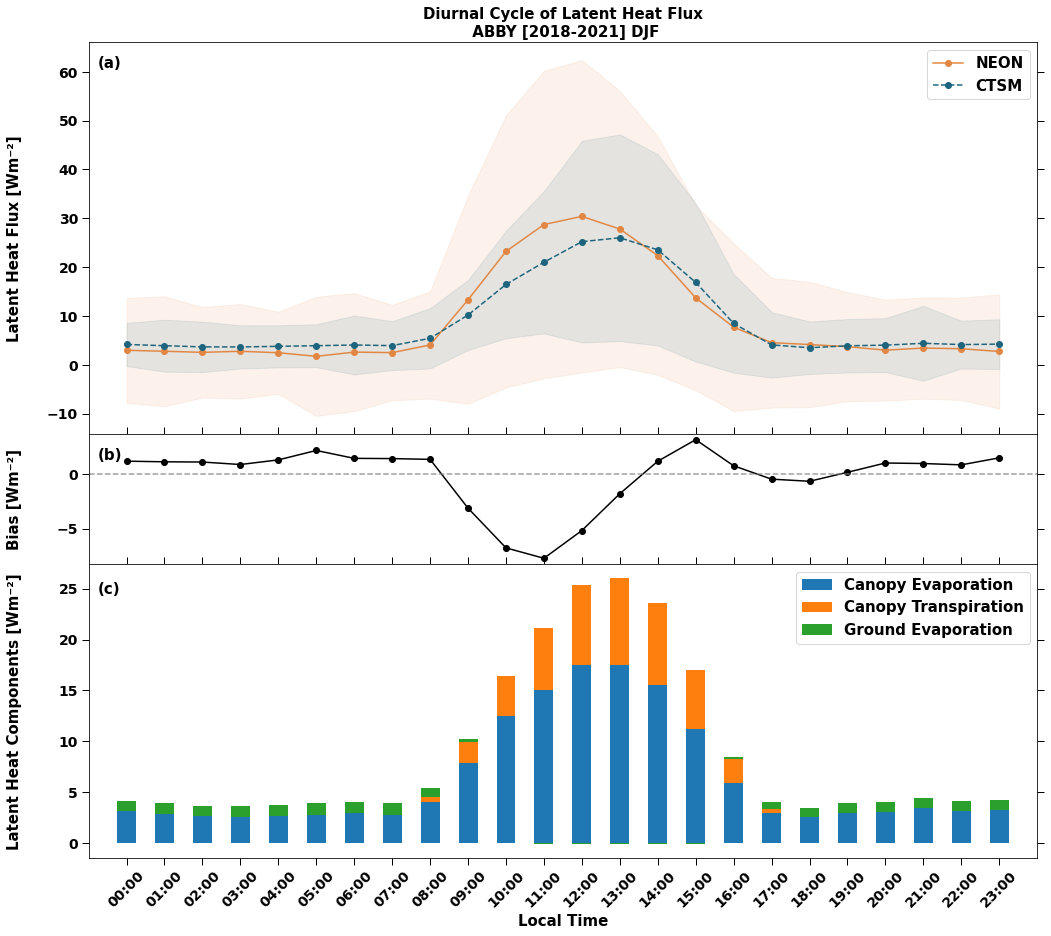

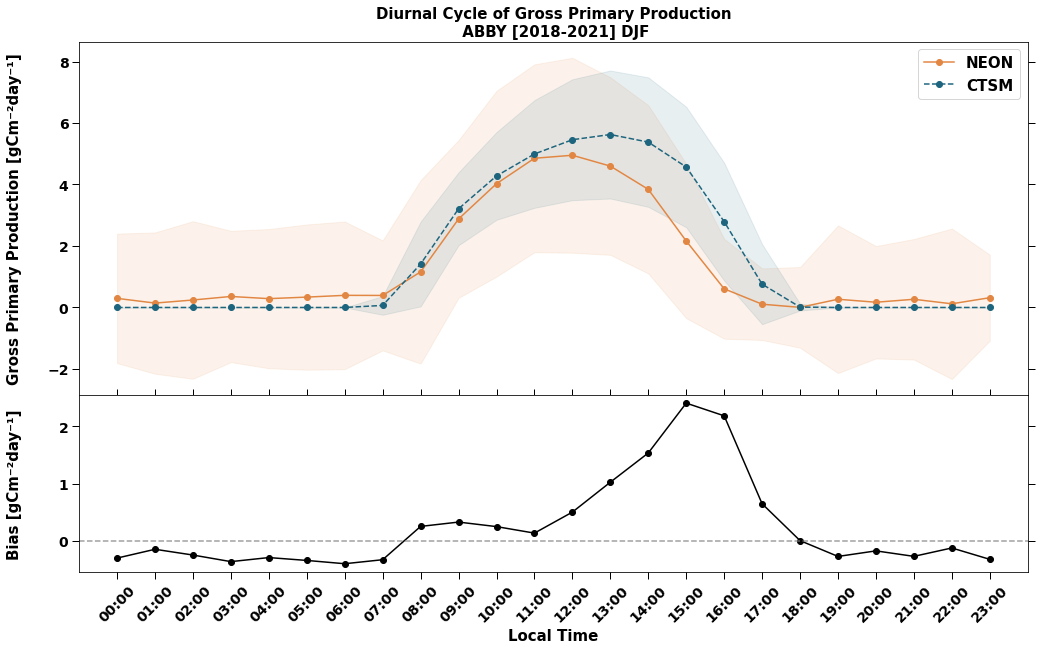

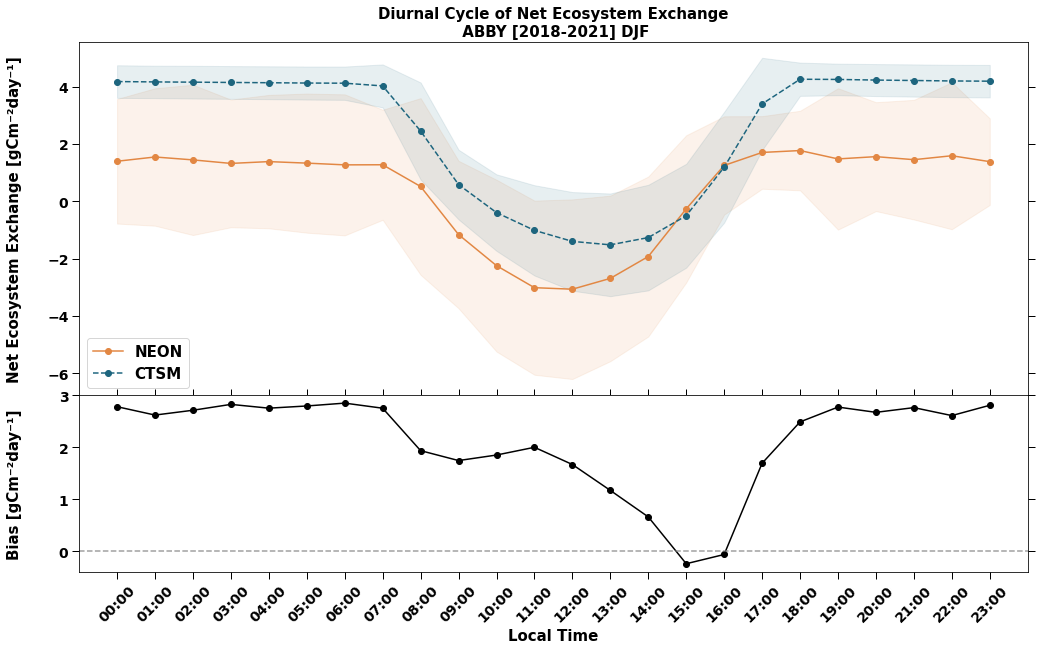

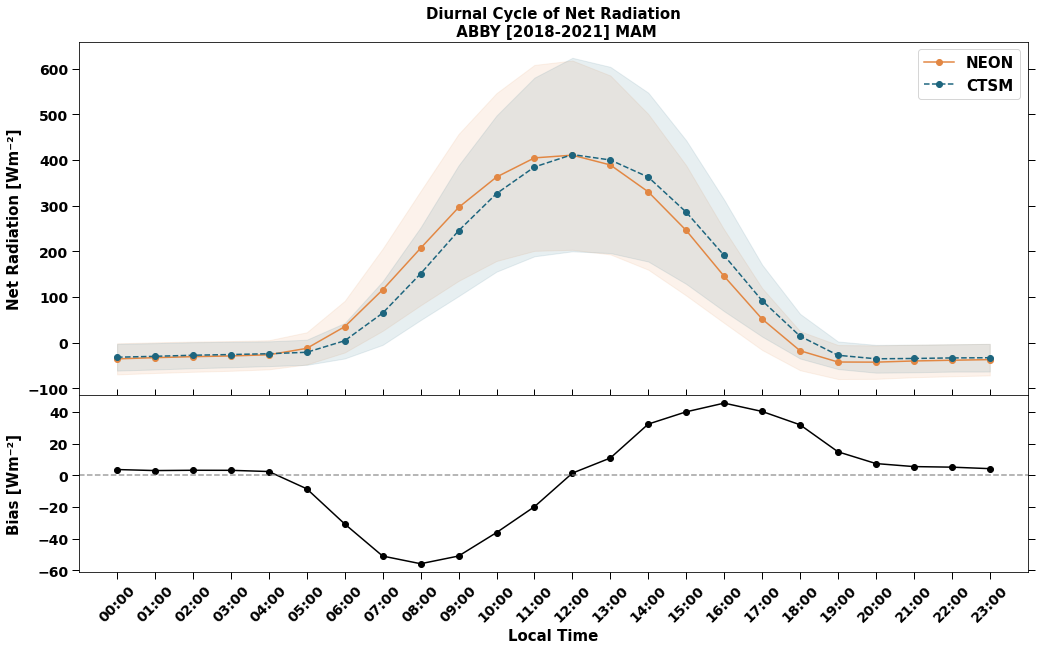

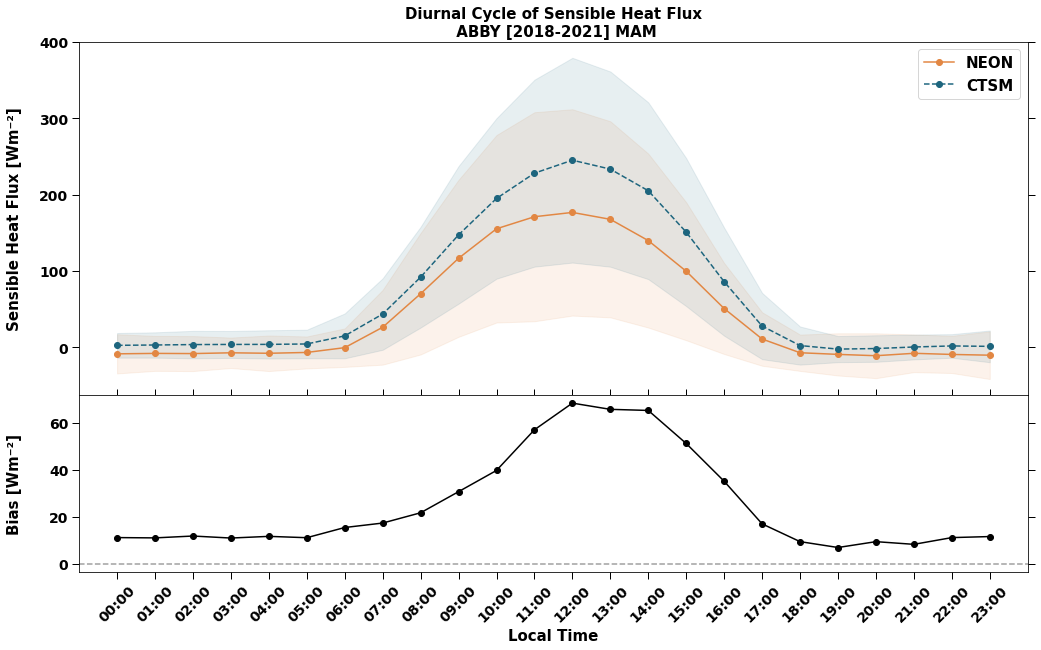

making latent heat component plots


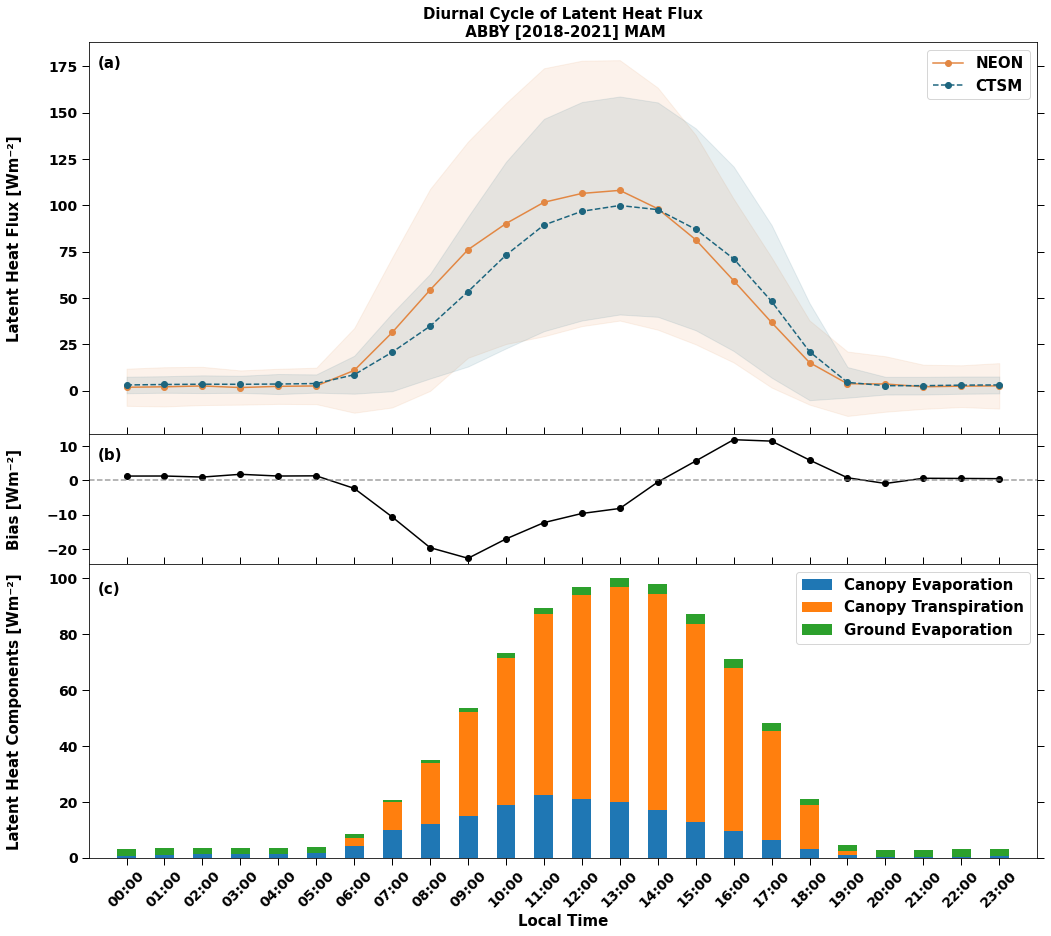

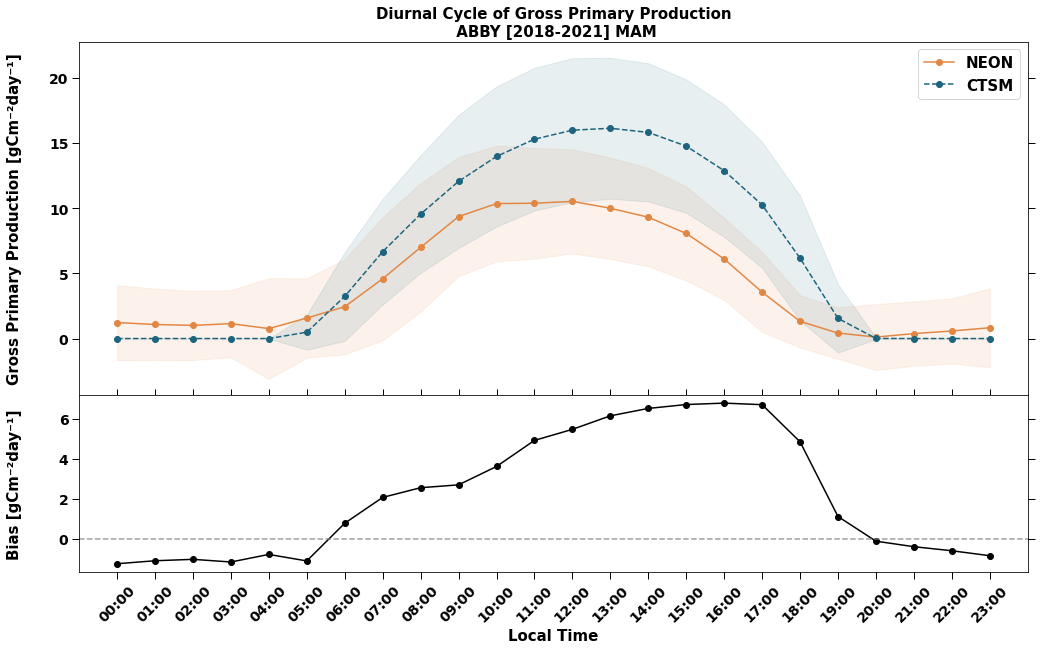

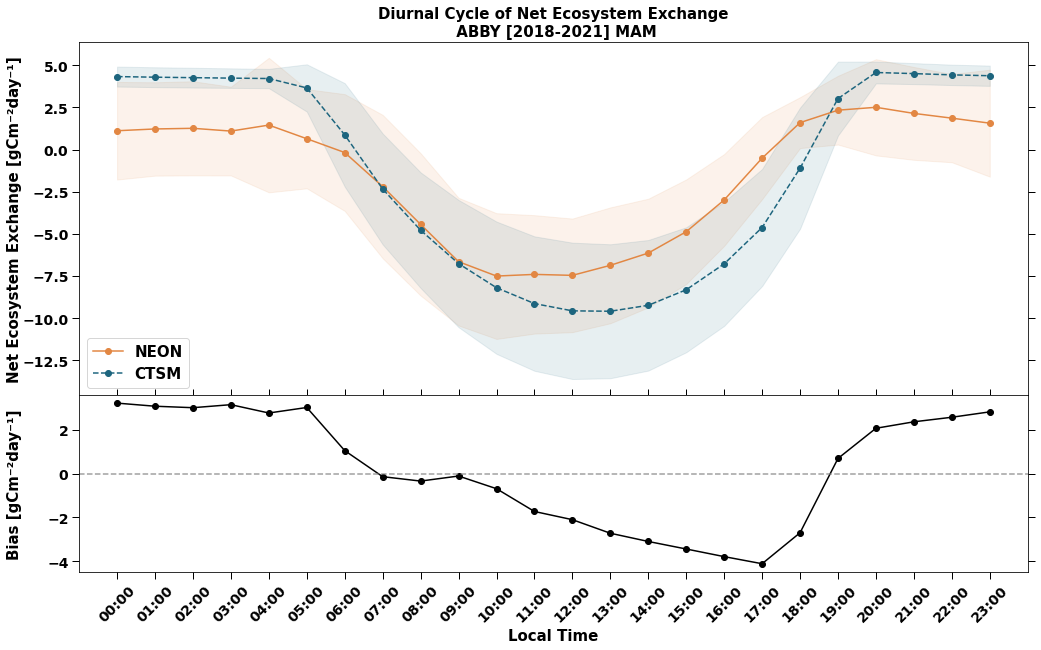

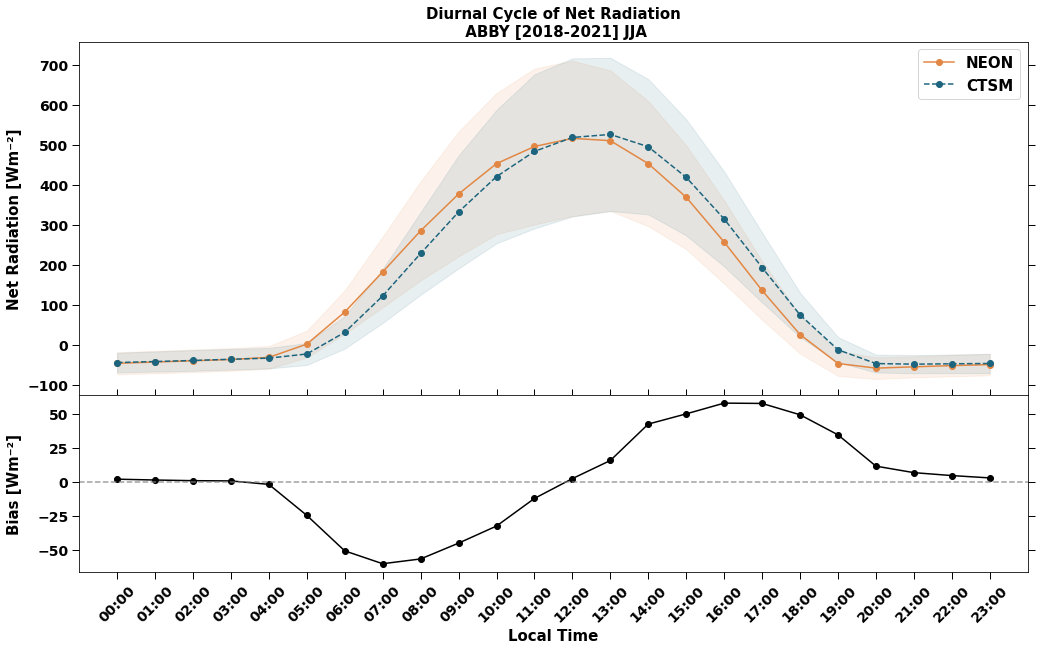

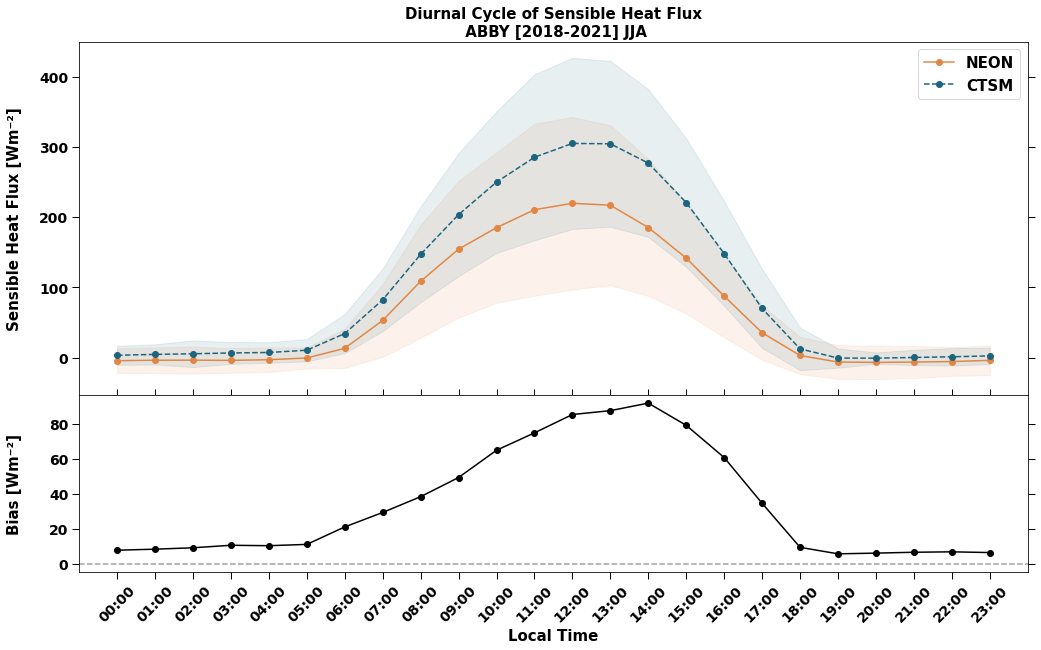

making latent heat component plots


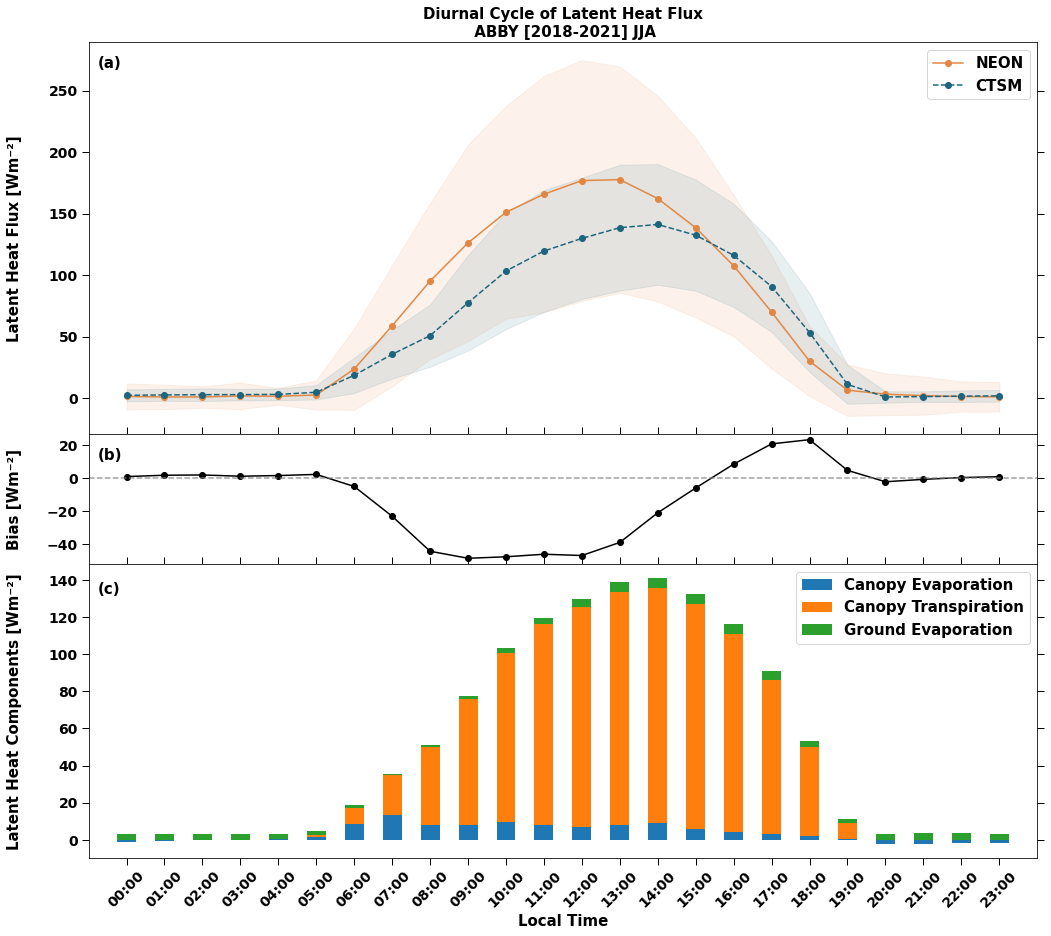

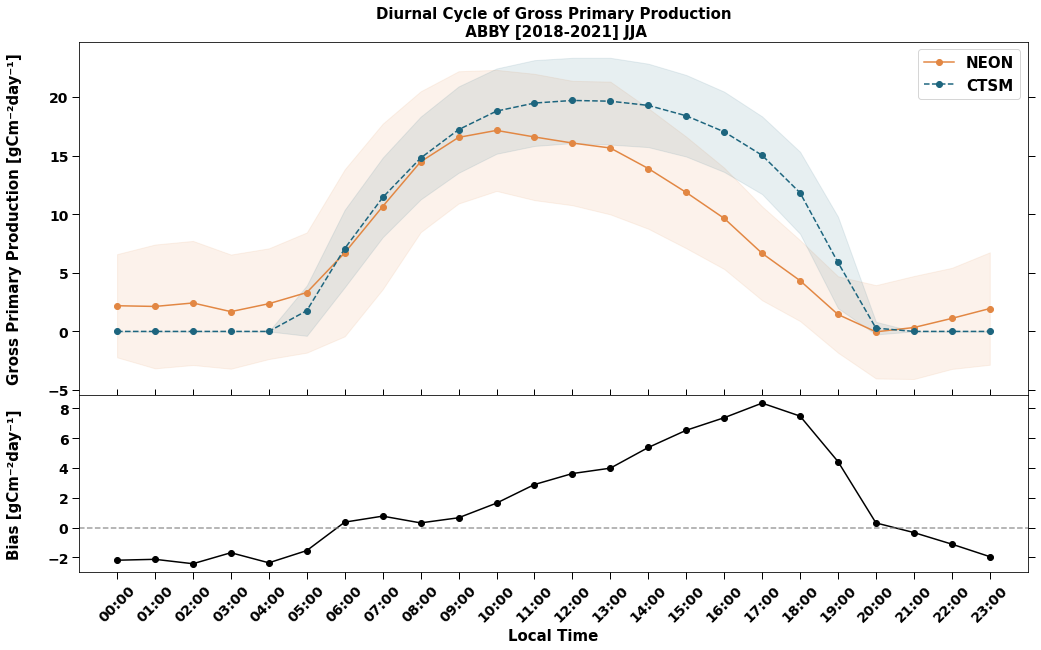

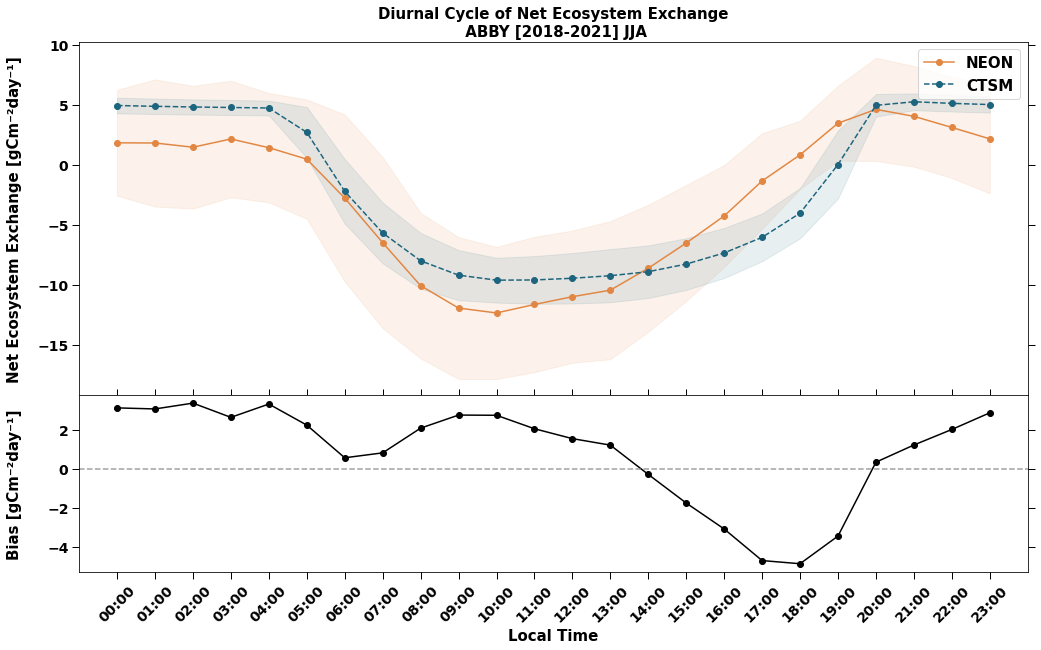

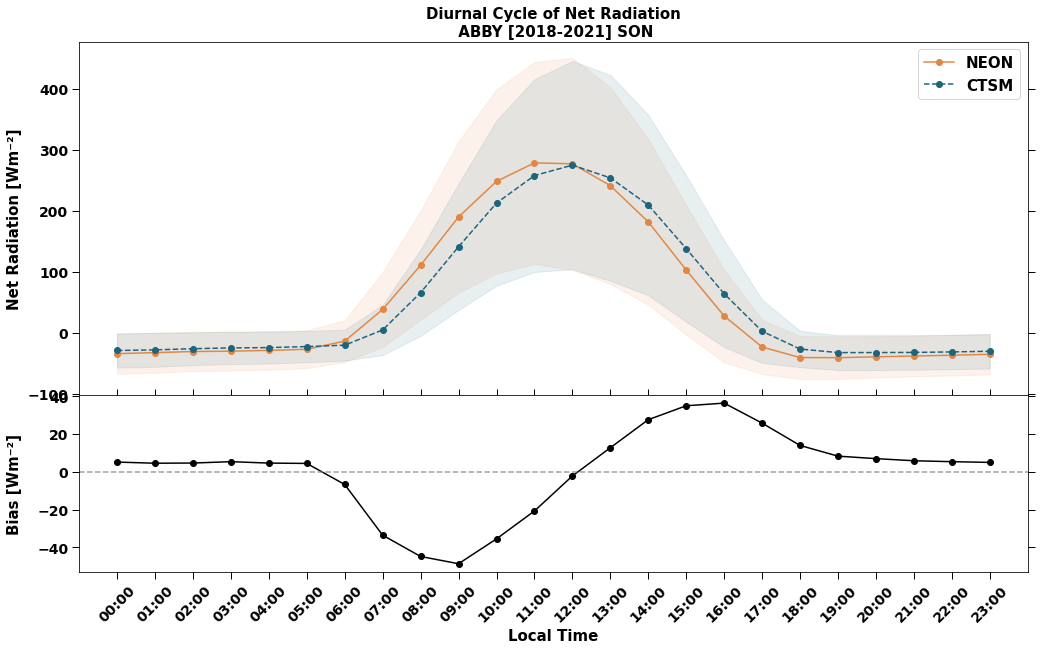

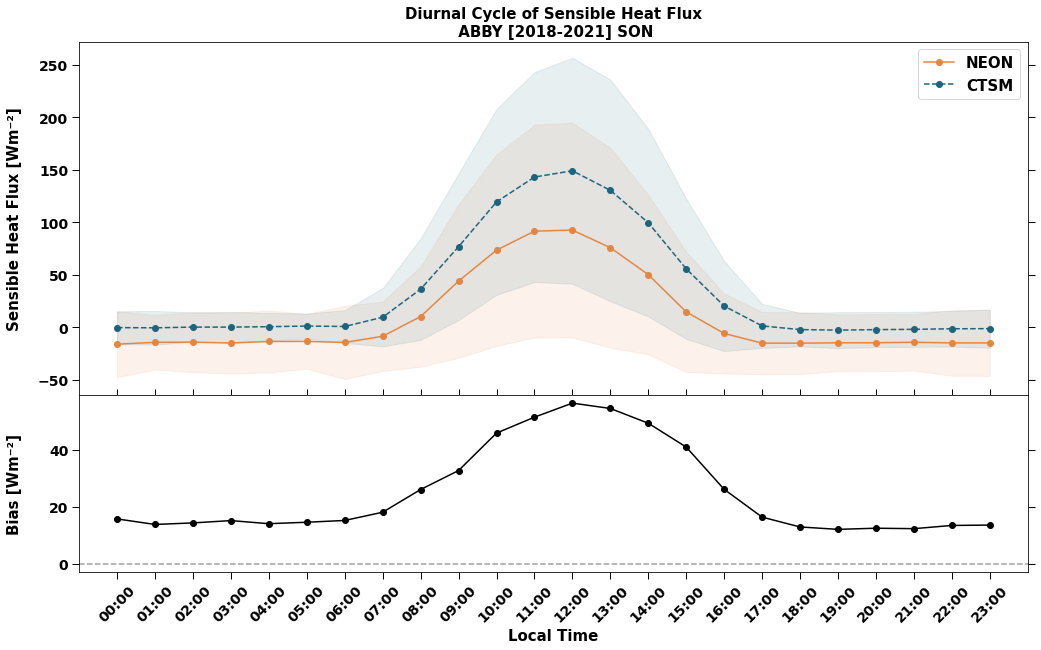

making latent heat component plots


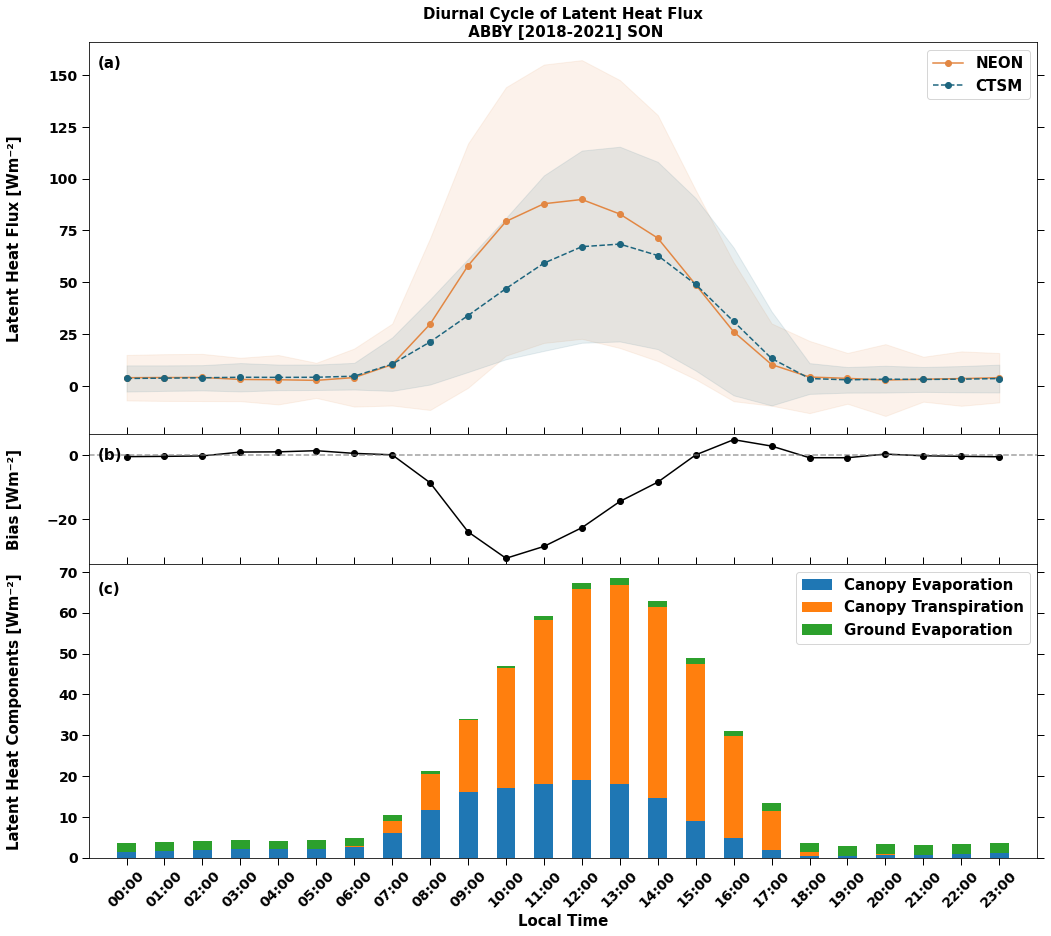

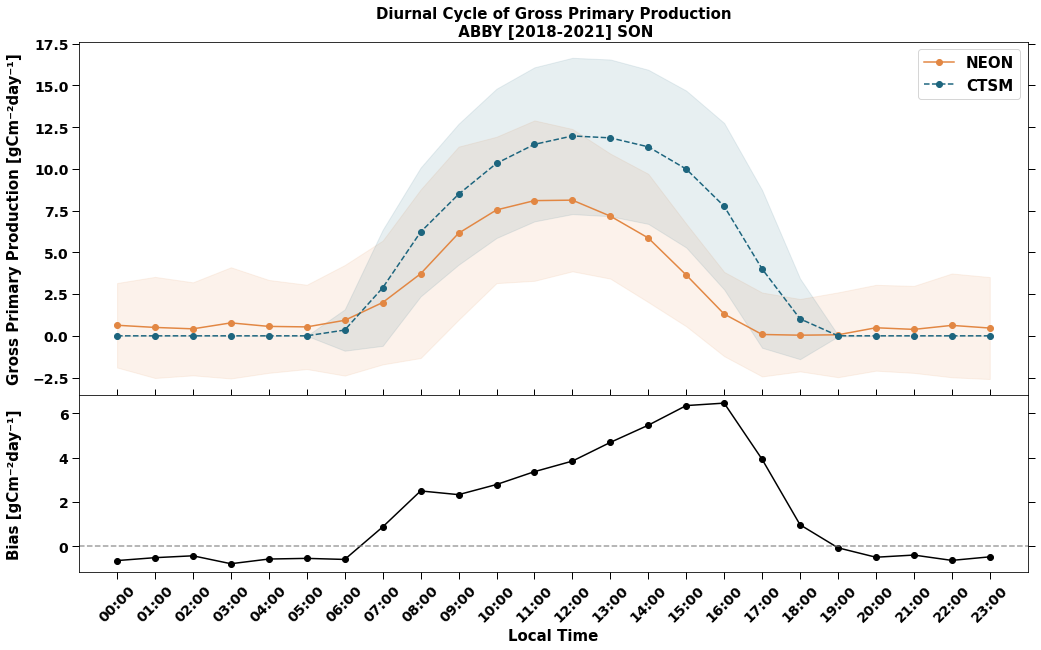

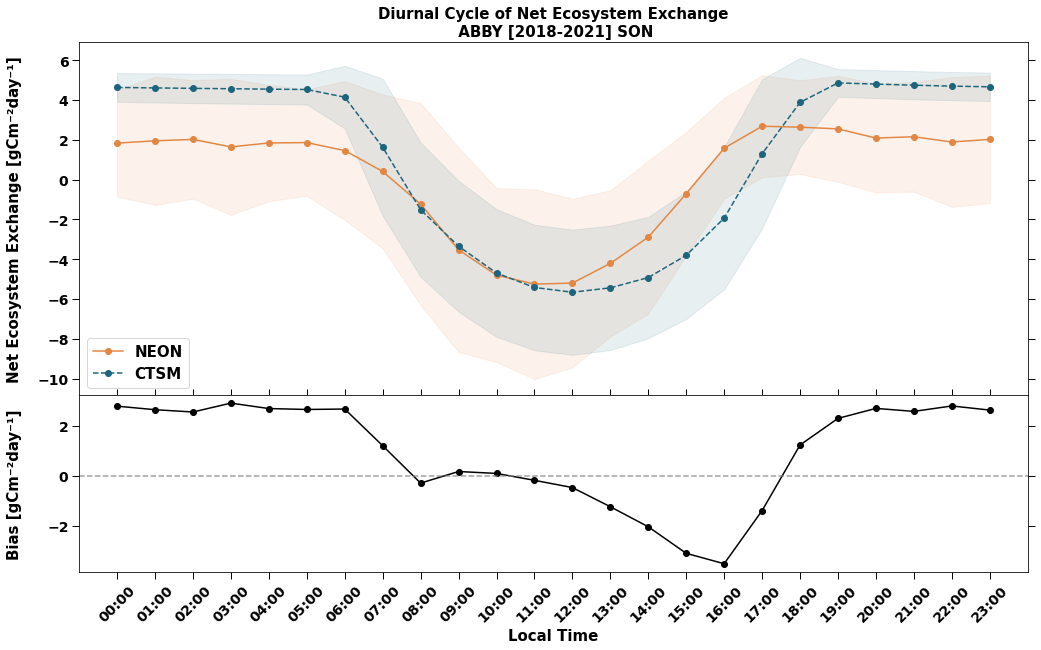

Making these plots for ABBY took :  43.49900197982788 s.
Making plots for  0 failed : 



In [13]:
save_switch = False
years = ["2018","2019","2020","2021"]

neon_sites = ['BART','ABBY']
for neon_site in neon_sites:
    try: 
        start_site = time.time()

        print ('---------------------------')
        print ("Making plots for "+neon_site)
        sim_files =[]
        for year in years:
            #sim_path = "/glade/scratch/negins/neon_v2/tools/site_and_regional/archive/"+neon_site+".transient/lnd/hist/"
            sim_path = "/glade/scratch/wwieder/run_NEON_v2/tools/site_and_regional/archive/"+neon_site+".transient/lnd/hist/"
            sim_files.extend(sorted(glob(join(sim_path,neon_site+".transient.clm2.h1."+year+"*.nc"))))

        print("All simulation files for all years: [", len(sim_files), "files]")
        print ("Start reading v2 simulation files...")
        
        
        start = time.time()

        ds_ctsm = xr.open_mfdataset(sim_files, decode_times=True, combine='by_coords',parallel=True,preprocess=preprocess, use_cftime=True)
        ds_ctsm = fix_time (ds_ctsm)
        end = time.time()
        print("Reading all simulation files took:", end-start, "s.")

        eval_files = []
        for year in years:
            eval_dir = "/glade/work/negins/neon_scripts/notebooks/evaluation_files_2/"+neon_site
            eval_files.extend(sorted(glob(join(eval_dir,neon_site+"_eval_"+year+"*.nc"))))

        print ("All evaluation files for all years: [", len(eval_files), "files]")
        print ("Start reading v2 evaluation files...")

        start = time.time()

        ds_eval = xr.open_mfdataset(eval_files, decode_times=True, combine='by_coords')

        end = time.time()
        print("Reading all observation files took:", end-start, "s.")

        print ("Processing data...")
        #Convert CTSM data to a Pandas Dataframe for easier handling:
        ctsm_vars = ['FCEV', 'FCTR', 'FGEV','FSH','GPP','FSA','FIRA','AR','HR','ELAI']

        df_ctsm = pd.DataFrame({'time':ds_ctsm.time})
        df_ctsm['time'] = pd.to_datetime(df_ctsm['time'],format= '%Y-%m-%d %H:%M:%S' )
        
        for var in ctsm_vars:
            sim_var_name = "sim_"+var
            field = np.ravel ( ds_ctsm[var])     
            df_ctsm[sim_var_name]=field
            
        #Convert NEON data to a Pandas Dataframe for easier handling:
        eval_vars = ['NEE','FSH','EFLX_LH_TOT','GPP','Rnet']

        df_all = pd.DataFrame({'time':ds_eval.time})

        for var in eval_vars:
            field = np.ravel (ds_eval[var])
            df_all[var]=field
        
        df_all=df_all.merge(df_ctsm.set_index('time'), on='time', how='left')
        
        clm_var = 'sim_EFLX_LH_TOT'
        # -- Latent Heat Flux:
        # -- EFLX_LH_TOT = FCEV + FCTR +FGEV
        df_all [clm_var] = df_all['sim_FCEV']+ df_all['sim_FCTR']+ df_all['sim_FGEV']

        clm_var = 'sim_Rnet'
        # -- Net Radiation:
        # -- Rnet = FSA-FIRA
        df_all [clm_var] = df_all ['sim_FSA']-df_all['sim_FIRA']

        clm_var = 'sim_NEE'
        # Net Ecosystem Exchange
        # NEE = GPP- (AR+HR)
        # It seems like the sign are opposite so we calculated negative NEE
        df_all [clm_var] = -(df_all ['sim_GPP']-(df_all['sim_AR']+df_all['sim_HR']))

        # convert NEE units from  umolm-2s-1 to gc/m2/s
        df_all ['NEE']= df_all ['NEE']*(12.01/1000000)
        df_all ['GPP']= df_all ['GPP']*(12.01/1000000)
        
        # -- convert gc/m2/s to gc/m2/day
        df_all ['NEE']= df_all['NEE']*60*60*24
        df_all ['sim_NEE']= df_all['sim_NEE']*60*60*24

        df_all ['GPP']= df_all['GPP']*60*60*24
        df_all ['sim_GPP']= df_all['sim_GPP']*60*60*24

        #-- extract year, month, day, hour information from time
        df_all['year'] = df_all['time'].dt.year
        df_all['month'] = df_all['time'].dt.month
        df_all['day'] = df_all['time'].dt.day
        df_all['hour'] = df_all['time'].dt.hour
        
        df_all['season'] = ((df_all['month']%12+3)//3).map({1:'DJF', 2: 'MAM', 3:'JJA', 4:'SON'})
        seasons = ['Annual','DJF', 'MAM', 'JJA', 'SON']

        #-- convert to local time
        tzone_shift = ds_eval.TimeDiffUtcLt
        df_all['local_time']= df_all['time'] + datetime.timedelta(hours=int(tzone_shift))
        df_all['local_hour'] = df_all['local_time'].dt.hour

        print ("Making diurnal cycle plots...")
        color1 = '#e28743'
        #color1 = '#f7aa15'
        color2 = '#1d657e'
        
        for season in seasons:
            if season=="Annual":
                #-- Calculate annual average diel cycle and bias
                diel_df_mean = df_all.groupby('local_hour').mean().reset_index()
                diel_df_std = df_all.groupby('local_hour').std().reset_index()
            
            else:
                df_season = df_all[df_all['season']==season]
                #-- Calculate annual average diel cycle and bias
                diel_df_mean = df_season.groupby('local_hour').mean().reset_index()
                diel_df_std = df_season.groupby('local_hour').std().reset_index()
                
            diel_df_mean['local_hour_dt']= pd.to_datetime(diel_df_mean['local_hour'], format='%H')


            for var in all_vars:

                if var.obs_var == "EFLX_LH_TOT":
                    print ("making latent heat component plots")
                    diel_cycle_lh(diel_df_mean, diel_df_std, var, plot_dir,color1,color2, season, save_switch)

                else:
                    diel_cycle_plot(diel_df_mean, diel_df_std, var, plot_dir,color1,color2, season, save_switch)
        
        
        end_site = time.time()
        print("Making these plots for "+neon_site+" took : ", end_site-start_site, "s.")
        plt.close('all')

    except Exception as e: 
        print (e)
        print ('THIS SITE FAILED:', neon_site)
        failed_sites.append(neon_site)
        pass

print ("Making plots for ", len(failed_sites), "failed : ")
print (*failed_sites, sep=" \n")